In [1]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import gaussian_filter1d
from tqdm.auto import tqdm
from itertools import product

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *
from trainers import *
from datatools import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# %matplotlib widget

# Set defaults, device
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)
if torch.cuda.is_available():
    device = 'cuda'
    synchronize = torch.cuda.synchronize
    empty_cache = torch.cuda.empty_cache
elif torch.backends.mps.is_available():
    device = 'mps'
    synchronize = torch.mps.synchronize
    empty_cache = torch.mps.empty_cache
else:
    device = "CPU"
    synchronize = lambda: None
    empty_cache = lambda: None

# Directories
main_dir = os.getcwd()
data_dir = os.path.join(main_dir, '..', '..', 'localdata')
model_cache_dir = os.path.join(data_dir, 'model_cache')
os.makedirs(model_cache_dir, exist_ok=True)
result_dir = os.path.join(data_dir, 'estimation_runs')
os.makedirs(result_dir, exist_ok=True)

In [3]:
ds = TimeWindowDatasetKinematics(os.path.join(data_dir, '2025-02-25_1'), 0.03, 
            select_x=['11'], 
            select_y=['rdlm'], # Just load one muscle so things run faster
            only_flapping=True, angles_only=True,
            use_ISI=False, use_phase=True, check_windows=True)

In [ ]:
ds.X[:,:,:]

torch.Size([8714, 1, 7])

In [5]:
ds = TimeWindowDataset(os.path.join(data_dir, '2025-02-25_1'),
    window_size=0.015, 
    select_x=['11', '18'], select_y=['lax', 'lba', 'lsa', 'ldvm', 'ldlm', 'rdlm', 'rdvm', 'rsa', 'rba', 'rax'],
    use_ISI=False, use_phase=True)

ds.n_windows

71681

In [3]:
ds.n_windows

17206

# Get embeddings for specific neuron used in figure 1, save data for Julia

Epoch: 1, DSIB, test: 0.1155569851398468
Epoch: 2, DSIB, test: 0.025880128145217896
Epoch: 3, DSIB, test: 0.018932640552520752
Epoch: 4, DSIB, test: 0.048530254513025284
Epoch: 5, DSIB, test: 0.11987430602312088
Epoch: 6, DSIB, test: 0.15189309418201447
Epoch: 7, DSIB, test: 0.2732670307159424
Epoch: 8, DSIB, test: 0.2564077377319336
Epoch: 9, DSIB, test: 0.30480051040649414
Epoch: 10, DSIB, test: 0.31864047050476074
Epoch: 11, DSIB, test: 0.3213247060775757
Epoch: 12, DSIB, test: 0.3470878601074219
Epoch: 13, DSIB, test: 0.3660612404346466
Epoch: 14, DSIB, test: 0.3510664403438568
Epoch: 15, DSIB, test: 0.34164032340049744
Epoch: 16, DSIB, test: 0.35766321420669556
Epoch: 17, DSIB, test: 0.36811164021492004
Epoch: 18, DSIB, test: 0.3798111379146576
Epoch: 19, DSIB, test: 0.3740736246109009
Epoch: 20, DSIB, test: 0.38609522581100464
Epoch: 21, DSIB, test: 0.4081231653690338
Epoch: 22, DSIB, test: 0.3784615099430084
Epoch: 23, DSIB, test: 0.35402384400367737
Epoch: 24, DSIB, test: 0.377

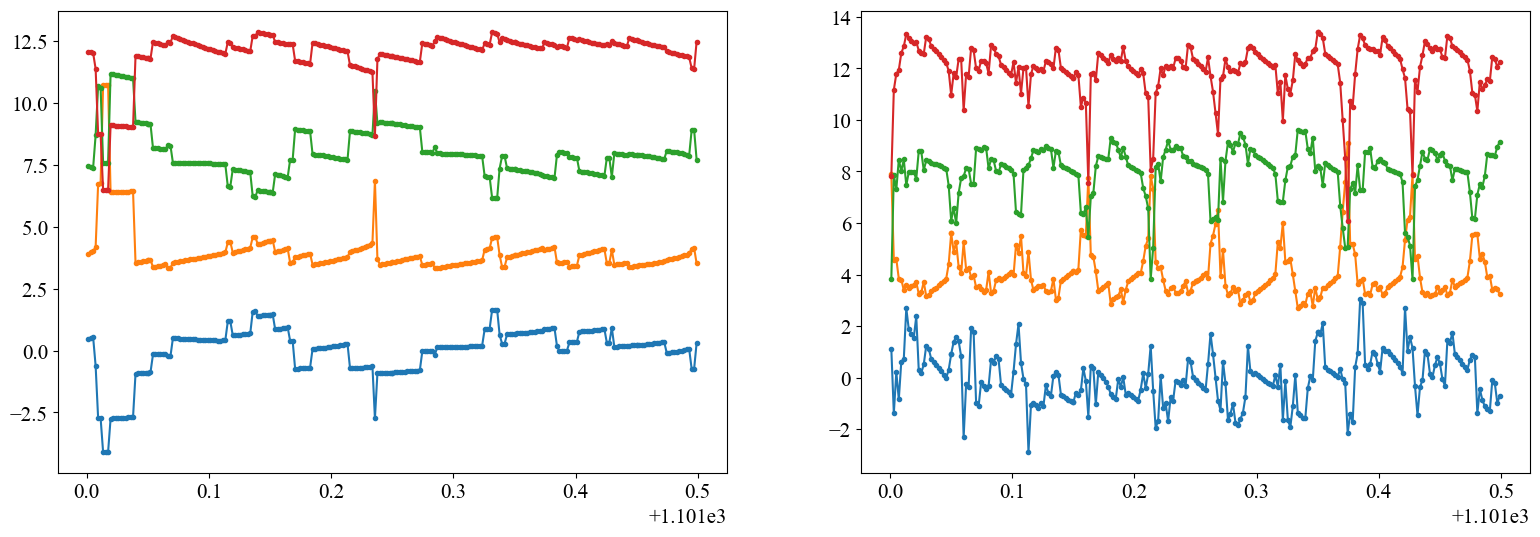

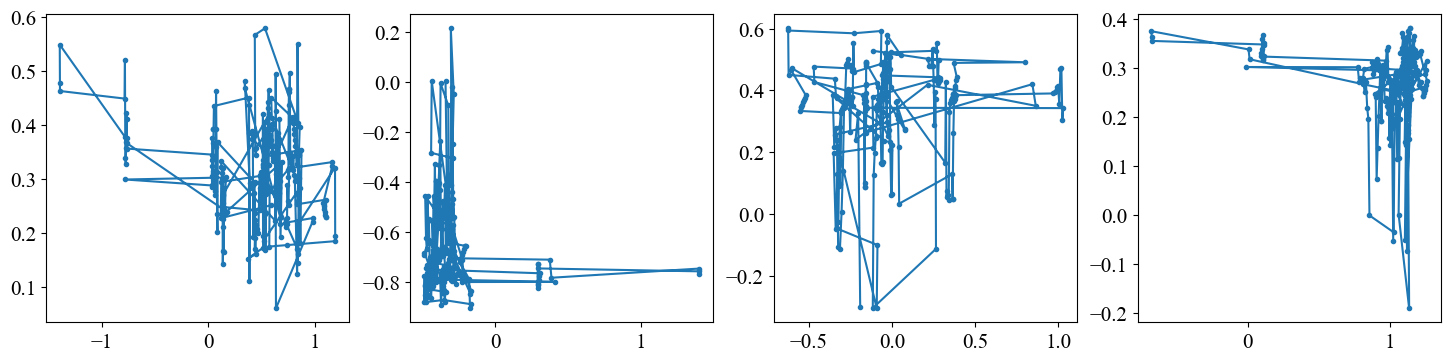

: 

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.1,
    'batch_size': 1024, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'patience': 100,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 20, # Number of epochs until random shifting is at max
    'start_shifting_epoch': 10,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 4,
    'hidden_dim': 128,
    'embed_dim': 4,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
time_shifts = np.linspace(0, params['window_size'], 50)
empty_cache()

# Train, then time shift
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-12_1'), 
    window_size=params['window_size'], 
    select_x=['97'], select_y=['lax', 'lba', 'lsa', 'ldvm', 'ldlm', 'rdlm', 'rdvm', 'rsa', 'rba', 'rax'],
    use_ISI=False, use_phase=True)
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)

mi = np.zeros_like(time_shifts)
embed_x, embed_y, window_times = [], [], []
with torch.no_grad():
    for i in range(len(time_shifts)):
        ds.move_data_to_windows(time_offset=time_shifts[i])
        window_times.append(ds.window_times[ds.valid_windows])
        mi[i] = - model(ds.X, ds.Y).detach().cpu().numpy()
        # Get X and Y embeddings for dataset at this time shift
        batch_size = ds.X.shape[0]
        zX = torch.zeros(batch_size, this_params['embed_dim'], device=ds.X.device)
        zY = torch.zeros(batch_size, this_params['embed_dim'], device=ds.X.device)
        for i in range(0, batch_size, this_params['max_n_batches']):
            end_idx = min(i + this_params['max_n_batches'], batch_size)
            zX[i:end_idx,:] = model.encoder_x(ds.X[i:end_idx,:,:])
            zY[i:end_idx,:] = model.encoder_y(ds.Y[i:end_idx,:,:])
        embed_x.append(zX.detach().cpu().numpy())
        embed_y.append(zY.detach().cpu().numpy())

def assemble_embeddings(window_times, embed_x, embed_y):
    all_times = np.concatenate(window_times)
    shift_indices = np.concatenate([np.repeat(i, window_times[i].shape[0]) for i in range(len(window_times))])
    inds = np.argsort(all_times)
    vals_x = np.concatenate(embed_x)[inds]
    vals_y = np.concatenate(embed_y)[inds]
    return all_times[inds], vals_x, vals_y, shift_indices[inds]

times, ex, ey, shift_indices = assemble_embeddings(window_times, embed_x, embed_y)

fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(19,6))
stime = 1101
mask = np.logical_and(times > stime, times < stime+0.5)
for i in range(ex.shape[1]):
    xval = (ex[mask,i] - np.mean(ex[mask,i])) / np.std(ex[mask,i])
    yval = (ey[mask,i] - np.mean(ey[mask,i])) / np.std(ey[mask,i])
    ax[0].plot(times[mask], xval + 4*i, '.-')
    ax[1].plot(times[mask], yval + 4*i, '.-')
plt.show()
fig, ax = plt.subplots(1, ex.shape[1], sharex=False, sharey=False, figsize=(18,4))
for i in range(ex.shape[1]):
    ax[i].plot(ex[mask,i], ey[mask,i], '.-')
plt.show()

# Save embeddings in time period
# filename = os.path.join(data_dir, 'fig_1_embedding_data.h5')
# save_dicts_to_h5([{'time': times, 'X': ex, 'Y': ey, 'shift_indices': shift_indices}], filename)

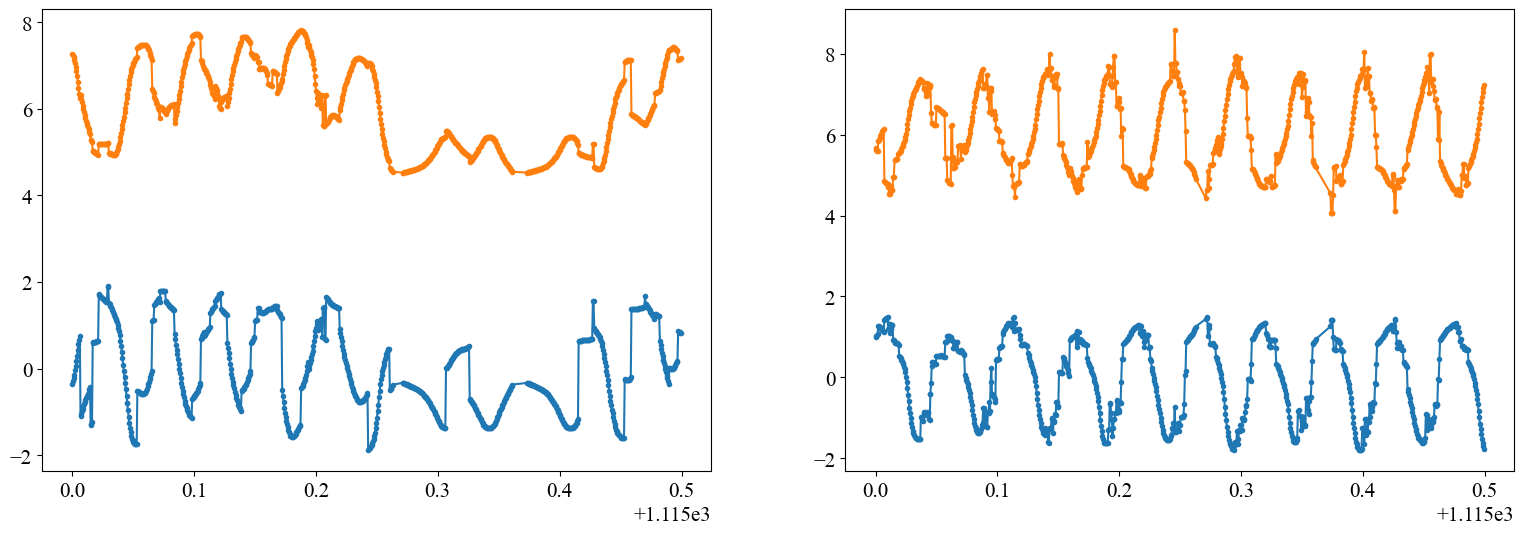

In [43]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(19,6))
stime = 1115
mask = np.logical_and(times > stime, times < stime+0.5)
for i in range(ex.shape[1]):
    xval = (ex[mask,i] - np.mean(ex[mask,i])) / np.std(ex[mask,i])
    yval = (ey[mask,i] - np.mean(ey[mask,i])) / np.std(ey[mask,i])
    ax[0].plot(times[mask], xval + 6*i, '.-')
    ax[1].plot(times[mask], yval + 6*i, '.-')
plt.show()

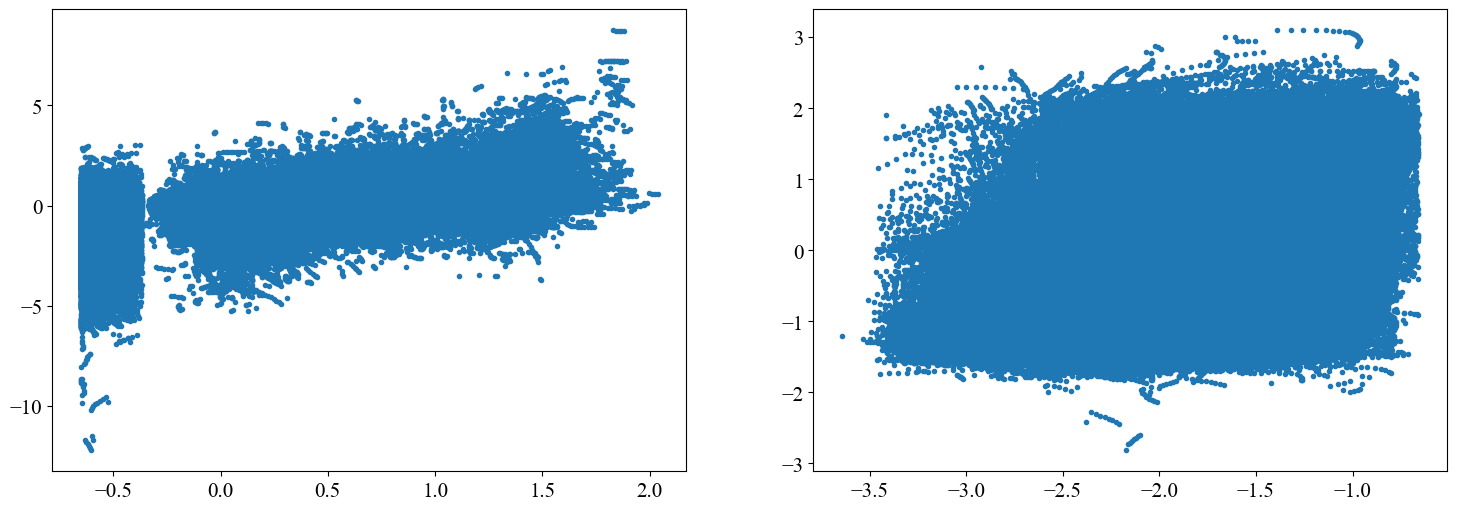

In [23]:
fig, ax = plt.subplots(1, ex.shape[1], sharex=False, sharey=False, figsize=(18,6))
for i in range(ex.shape[1]):
    ax[i].plot(ex[:,i], ey[:,i], '.')
plt.show()

# Get train/test curve for figure 2

Epoch: 1, DSIB, test: 0.015501797199249268
Epoch: 2, DSIB, test: 0.061634667217731476
Epoch: 3, DSIB, test: 0.0678059309720993
Epoch: 4, DSIB, test: 0.046984270215034485
Epoch: 5, DSIB, test: 0.10517805814743042
Epoch: 6, DSIB, test: 0.10088249295949936
Epoch: 7, DSIB, test: 0.08385489135980606
Epoch: 8, DSIB, test: 0.10284410417079926
Epoch: 9, DSIB, test: 0.029332445934414864
Epoch: 10, DSIB, test: 0.12404036521911621
Epoch: 11, DSIB, test: 0.09258808195590973
Epoch: 12, DSIB, test: 0.14135973155498505
Epoch: 13, DSIB, test: 0.08648834377527237
Epoch: 14, DSIB, test: 0.09419679641723633
Epoch: 15, DSIB, test: 0.08462066203355789
Epoch: 16, DSIB, test: 0.06123654916882515
Epoch: 17, DSIB, test: 0.13832922279834747
Epoch: 18, DSIB, test: 0.09437492489814758
Epoch: 19, DSIB, test: 0.16074401140213013
Epoch: 20, DSIB, test: 0.12470297515392303
Epoch: 21, DSIB, test: 0.1271912008523941
Epoch: 22, DSIB, test: 0.1332101970911026
Epoch: 23, DSIB, test: 0.15215060114860535
Epoch: 24, DSIB, te

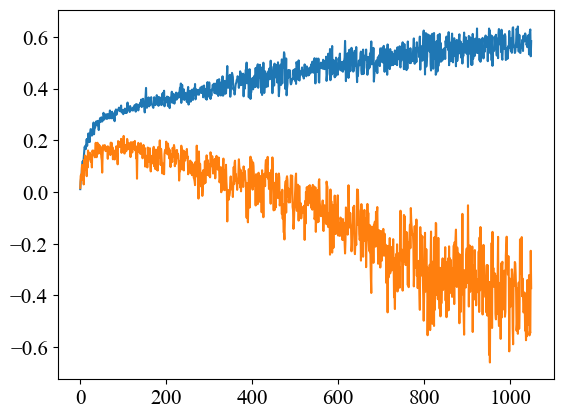

In [4]:
params = {
    # Optimizer parameters (for training)
    'epochs': 1050,
    'window_size': 0.046896551724137925,
    'batch_size': 1024, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'patience': 1000,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 20, # Number of epochs until random shifting is at max
    'start_shifting_epoch': 10,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 4,
    'hidden_dim': 128,
    'embed_dim': 4,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
time_shifts = np.linspace(0, params['window_size'], 50)
empty_cache()

# Train, then time shift
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), 
    window_size=params['window_size'], 
    select_x=['6'], select_y=['lax', 'lba', 'lsa', 'ldvm', 'ldlm', 'rdlm', 'rdvm', 'rsa', 'rba', 'rax'], # 6
    use_ISI=False, use_phase=True)
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
mis_test, mis_train, train_id = train_model_with_eval(ds, this_params, X='X', Y='Y', verbose=True)
model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)

# Save train and test curves
filename = os.path.join(data_dir, 'fig_2_train_test_data.h5')
save_dicts_to_h5([{'train': mis_train, 'test': mis_test}], filename)

fig, ax = plt.subplots()
ax.plot(mis_train)
ax.plot(mis_test)
plt.show()

# Training a network on fake spikes to see how much MI you get from low overall spike count neurons

Epoch: 1, DSIB, test: 1.72529871633742e-05
Epoch: 2, DSIB, test: 1.4083798127728642e-08
Epoch: 3, DSIB, test: 6.570091954927193e-06
Epoch: 4, DSIB, test: 8.892912433111633e-07
Epoch: 5, DSIB, test: 4.175846243015258e-06
Epoch: 6, DSIB, test: -4.211726150060713e-07
Epoch: 7, DSIB, test: 2.820112854351464e-07
Epoch: 8, DSIB, test: -3.1044714887684677e-06
Epoch: 9, DSIB, test: 2.199084519816097e-06
Epoch: 10, DSIB, test: -3.964924417232396e-06
Epoch: 11, DSIB, test: -1.6095768273771682e-08
Epoch: 12, DSIB, test: 2.421072053948592e-07
Epoch: 13, DSIB, test: -1.1568833713226923e-07
Epoch: 14, DSIB, test: -1.7302951960118662e-07
Epoch: 15, DSIB, test: 5.175124897505157e-06
Epoch: 16, DSIB, test: -2.545143615861889e-07
Epoch: 17, DSIB, test: 2.679274757610983e-07
Epoch: 18, DSIB, test: -5.5999862524913624e-08
Epoch: 19, DSIB, test: -1.1736497995684658e-08
Epoch: 20, DSIB, test: -1.17029657076273e-07
Epoch: 21, DSIB, test: -2.682628119643482e-09
Epoch: 22, DSIB, test: -3.5645422258312465e-07
E

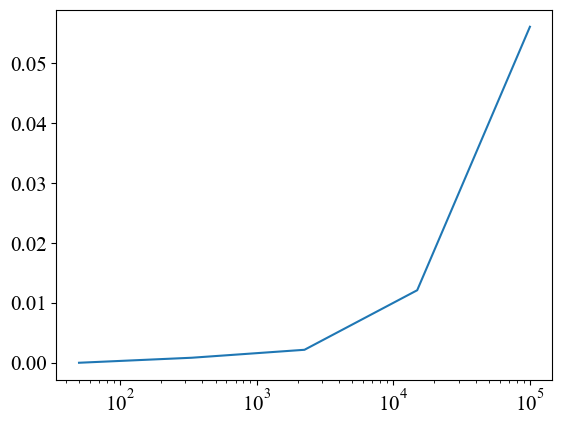

In [5]:
params = {
        # Optimizer parameters (for training)
        'epochs': 300,
        'window_size': 0.05,
        'batch_size': 1024, # Number of windows estimator processes at any time
        'learning_rate': 5e-3,
        'patience': 100,
        'min_delta': 0.001,
        'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
        'train_fraction': 0.95,
        'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
        'epochs_till_max_shift': 20, # Number of epochs until random shifting is at max
        'start_shifting_epoch': 10,
        'model_cache_dir': model_cache_dir,
        # Critic parameters for the estimator
        'model_func': DSIB, # DSIB or DVSIB
        'activation': nn.LeakyReLU,
        'layers': 4,
        'hidden_dim': 128,
        'embed_dim': 10,
        'use_bias': False,
        'beta': 512, # Just used in DVSIB
        'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
        'mode': 'sep', # Almost always we'll use separable
        'max_n_batches': 1024, # If input has more than this many batches, encoder runs are split up for memory management
    }
nspike_range = np.round(np.logspace(np.log10(50), np.log10(100000), 5)).astype(int)
mi = np.zeros(len(nspike_range))
for i,nspike in enumerate(nspike_range):
    # All muscles together
    ds = TimeWindowDataset(os.path.join(data_dir, '2025-02-25_1'), 
        window_size=params['window_size'],
        select_x=['42069'], use_ISI=False, use_phase=True,
        nspike=nspike, check_windows=False)

    this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
    mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
    model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)

    ds.move_data_to_windows(0)
    with torch.no_grad():
        mi[i] = - model(ds.X, ds.Y).detach().cpu().numpy()
        print(mi[i])

fig, ax = plt.subplots()
plt.plot(nspike_range, mi)
ax.set_xscale('log')
plt.show()

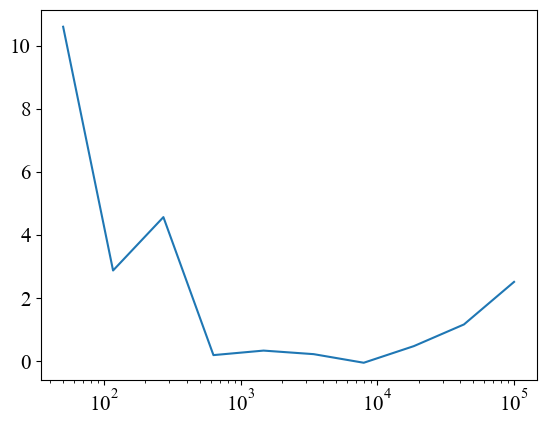

In [5]:
fig, ax = plt.subplots()
plt.plot(nspike_range, mi/0.05)
ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

In [8]:
params = {
        # Optimizer parameters (for training)
        'epochs': 300,
        'window_size': 0.05,
        'batch_size': 1024, # Number of windows estimator processes at any time
        'learning_rate': 5e-3,
        'patience': 100,
        'min_delta': 0.001,
        'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
        'train_fraction': 0.95,
        'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
        'epochs_till_max_shift': 20, # Number of epochs until random shifting is at max
        'start_shifting_epoch': 10,
        'model_cache_dir': model_cache_dir,
        # Critic parameters for the estimator
        'model_func': DSIB, # DSIB or DVSIB
        'activation': nn.LeakyReLU,
        'layers': 4,
        'hidden_dim': 128,
        'embed_dim': 10,
        'use_bias': False,
        'beta': 512, # Just used in DVSIB
        'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
        'mode': 'sep', # Almost always we'll use separable
        'max_n_batches': 1024, # If input has more than this many batches, encoder runs are split up for memory management
    }

ds = TimeWindowDataset(os.path.join(data_dir, '2025-02-25'), 
    window_size=params['window_size'],
    select_x=['41'], use_ISI=False, use_phase=True, check_windows=True)
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
ds.move_data_to_windows(0)
with torch.no_grad():
    mi0 = - model(ds.X, ds.Y).detach().cpu().numpy()
    print(f'Check windows mi: {mi0}')
print(mi0 * np.sum(ds.valid_windows) / np.sum(ds.bout_ends - ds.bout_starts))

ds = TimeWindowDataset(os.path.join(data_dir, '2025-02-25'), 
    window_size=params['window_size'],
    select_x=['41'], use_ISI=False, use_phase=True, check_windows=False)
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
ds.move_data_to_windows(0)
with torch.no_grad():
    mi1 = - model(ds.X, ds.Y).detach().cpu().numpy()
    print(f'No check windows mi: {mi1}')
print(mi1 * np.sum(ds.valid_windows) / np.sum(ds.bout_ends - ds.bout_starts))


Epoch: 1, DSIB, test: 0.02593052387237549
Epoch: 2, DSIB, test: 0.09297481179237366
Epoch: 3, DSIB, test: 0.3592827320098877
Epoch: 4, DSIB, test: 0.06643646955490112
Epoch: 5, DSIB, test: 0.5926277041435242
Epoch: 6, DSIB, test: 0.5979926586151123
Epoch: 7, DSIB, test: 0.5445871949195862
Epoch: 8, DSIB, test: 0.4450756907463074
Epoch: 9, DSIB, test: 0.4334820508956909
Epoch: 10, DSIB, test: 0.5394765138626099
Epoch: 11, DSIB, test: 0.6382393836975098
Epoch: 12, DSIB, test: 0.6787005662918091
Epoch: 13, DSIB, test: 0.689394474029541
Epoch: 14, DSIB, test: 0.677053689956665
Epoch: 15, DSIB, test: 0.6719195246696472
Epoch: 16, DSIB, test: 0.6795827150344849
Epoch: 17, DSIB, test: 0.6766008138656616
Epoch: 18, DSIB, test: 0.6745361089706421
Epoch: 19, DSIB, test: 0.6791220903396606
Epoch: 20, DSIB, test: 0.6850366592407227
Epoch: 21, DSIB, test: 0.688697338104248
Epoch: 22, DSIB, test: 0.6911273002624512
Epoch: 23, DSIB, test: 0.6927531957626343
Epoch: 24, DSIB, test: 0.6928985118865967
E

In [12]:
np.sum(ds.bout_ends - ds.bout_starts) / 0.05

15488.739999999982

In [13]:
np.sum(ds.valid_windows)

15482

In [9]:
np.sum(ds.valid_windows) / np.sum(ds.bout_ends - ds.bout_starts)

19.991296903427934

In [17]:
print(mi1 * np.sum(ds.valid_windows) / np.sum(ds.bout_ends - ds.bout_starts))
print(mi1 * np.sum(ds.bout_ends - ds.bout_starts) / 0.05)

0.17832573699444793
138.1621707164867


# Test to see what's up with varying window size on some neurons

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.04,
    # 'batch_size': 512, # Number of windows estimator processes at any time
    's_per_batch': 25, # Alternatively specify seconds of data a batch should be
    'learning_rate': 5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 10, # Number of epochs until random shifting is at max
    'start_shifting_epoch': 10,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.PReLU,
    'layers': 3,
    'hidden_dim': 1024,
    'embed_dim': 12,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))

# # All muscles together
ds = TimeWindowDataset(os.path.join(data_dir, '2025-02-25_1'), 
    window_size=params['window_size'])

KeyError: 'start_shifting_epoch'

In [149]:
moths = [
    "2025-02-25_1",
    "2025-02-25",
    "2025-03-11",
    "2025-03-12_1",
    "2025-03-20",
    "2025-03-21"
]
total_good = 0
total_mua = 0
for moth in moths:
    ds = TimeWindowDataset(os.path.join(data_dir, moth), window_size=params['window_size'])
    print(f'Moth {moth} good units: {np.sum(np.array(ds.neuron_quality) == 1)} MUA units: {np.sum(np.array(ds.neuron_quality) == 0)}')
    total_good += np.sum(np.array(ds.neuron_quality) == 1)
    total_mua += np.sum(np.array(ds.neuron_quality) == 0)
print(total_good)
print(total_mua)


Moth 2025-02-25_1 good units: 17 MUA units: 13
Moth 2025-02-25 good units: 22 MUA units: 13
Moth 2025-03-11 good units: 12 MUA units: 8
Moth 2025-03-12_1 good units: 28 MUA units: 18
Moth 2025-03-20 good units: 12 MUA units: 5
Moth 2025-03-21 good units: 23 MUA units: 9
114
66


Checks on dataset class: Everything makes sense?

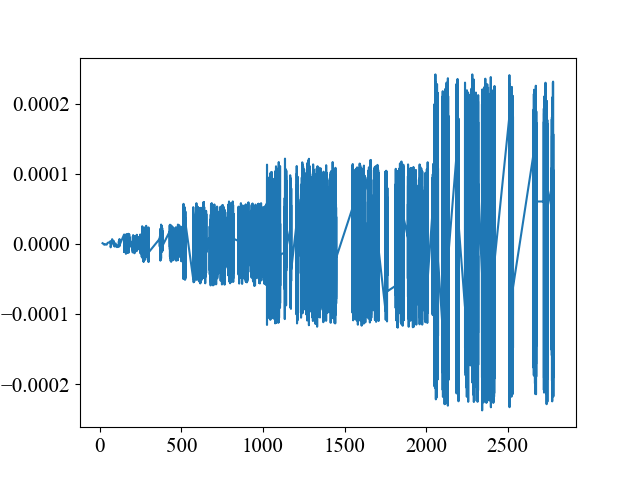

In [8]:
ds = TimeWindowDatasetKinematics(os.path.join(data_dir, '2025-02-25_1'), 
        window_size=params['window_size'], neuron_label_filter=1, 
        only_flapping=False,
        angles_only=True,
        time_offset=0.01)

# Reconstruct original spike times, see what the fuck is happening
i = 1
plt.figure()

window_inds_x = [np.searchsorted(ds.window_times, x) - 1 for x in ds.Xtimes]
mask = ds.valid_windows[window_inds_x[i]]
inds = ds.Xmain[:,i,:].nonzero()
_, index, counts = np.unique(window_inds_x[i], return_counts=True, return_index=True)
# xmain = ds.Xmain[inds[:,0],i,inds[:,1]].detach().cpu().numpy()
xmain = ds.Xmain.detach().cpu().numpy()
times = []
for wi in range(xmain.shape[0]):
    vals = np.cumsum(xmain[wi,i,xmain[wi,i,:] != 0]) + ds.window_times[ds.valid_windows][wi]
    times.append(vals)
    # for ci in range(xmain.shape[2]):
    #     if xmain[wi,i,ci] != 0:
    #         val = xmain[wi,i,ci] + ds.window_times[ds.valid_windows][wi]
    #         times.append(val)
times = np.concatenate(times)
plt.plot(ds.Xtimes[i][mask], times - ds.Xtimes[i][mask])
# for ii,idx in enumerate(index):
#     test[idx:idx+counts[ii]] = np.cumsum(xmain[idx:idx+counts[ii]]) + ds.window_times[window_inds_x[i]][mask][idx:idx+counts[ii]]
# test = ds.Xmain[inds[:,0],i,inds[:,1]].detach().cpu().numpy() + ds.window_times[window_inds_x[i]][mask]
# plt.plot(ds.Xtimes[i][mask], test - ds.Xtimes[i][mask])

# window_inds_y = [np.searchsorted(ds.window_times, x) - 1 for x in ds.Ytimes]
# mask = ds.valid_windows[window_inds_y[i]]
# inds = ds.Ymain[:,i,:].nonzero()
# test = ds.Ymain[inds[:,0],i,inds[:,1]].detach().cpu().numpy() + ds.window_times[window_inds_y[i]][mask]
# plt.plot(ds.Ytimes[i][mask], test - ds.Ytimes[i][mask])

# plt.vlines(ds.bout_starts, ymin=0, ymax=1)
plt.show()


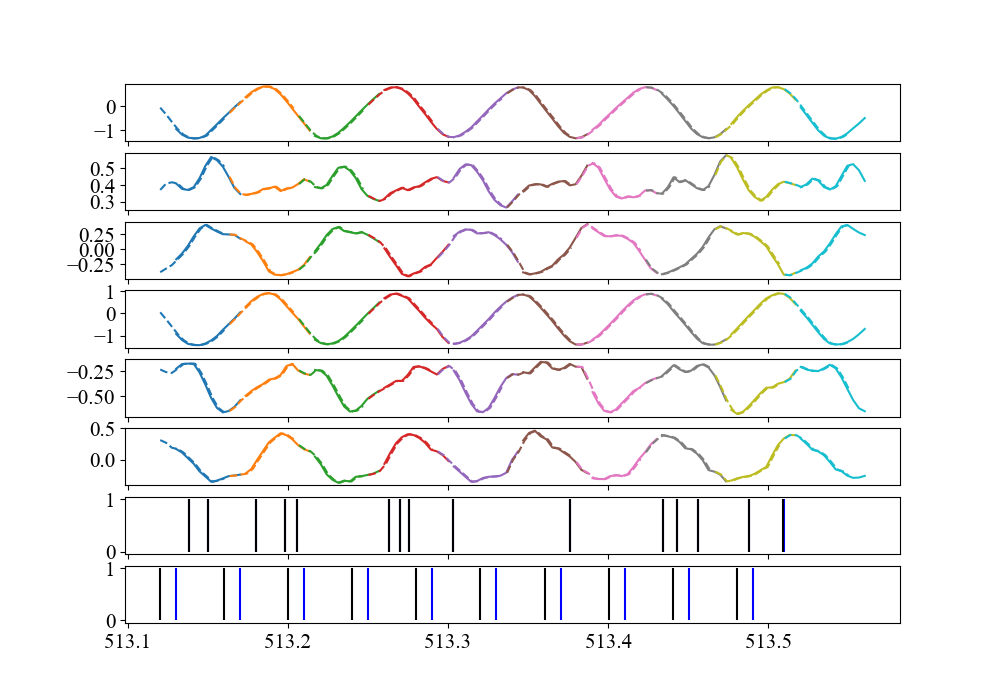

In [3]:
# target_time = 98.248
target_time = 513.1352

fig, ax = plt.subplots(8,1, sharex=True, figsize=(10,7))
bob = ['-', '--']
for ii,offset in enumerate([0, 0.03]):
    ds = TimeWindowDatasetKinematics(os.path.join(data_dir, '2025-02-25_1'), 
        window_size=params['window_size'], neuron_label_filter=1, 
        only_flapping=False,
        # only_valid_kinematics=False, 
        angles_only=True,
        time_offset=offset)
    
    ind = np.argmin(np.abs(ds.window_times[ds.valid_windows] - target_time))

    col = 'k' if ii == 1 else 'b'
    Zmain = ds.Zmain.detach().clone().cpu().numpy()
    for i in range(6):
        for j in range(10):
            xvec = ds.window_times[ds.valid_windows][ind+j]  + np.linspace(0, ds.window_size, Zmain.shape[2]) + (np.mean(np.diff(ds.Ztimes[:10])) * j)
            ax[i].plot(xvec, Zmain[ind+j,i,:], linestyle=bob[ii])
    for j in range(10):
        vals = ds.Xmain[ind+j,5,:].detach().clone().cpu().numpy()
        ax[6].vlines(ds.window_times[ds.valid_windows][ind+j] + np.cumsum(vals[np.where(vals != 0)]), ymin=0, ymax=1, color=col)

    for j in range(10):
        ax[7].vlines(ds.window_times[ds.valid_windows][ind+j], ymin=0, ymax=1, color=col)

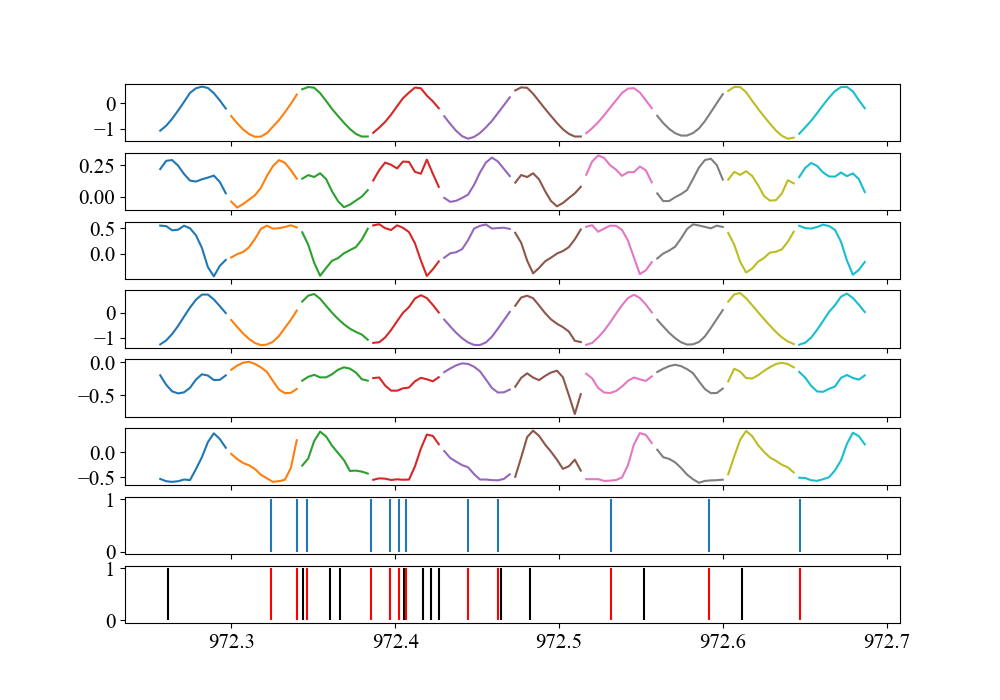

In [7]:
# Check dataset class is working plausibly
target_time = 513.1352

ds = TimeWindowDatasetKinematics(os.path.join(data_dir, '2025-02-25_1'), 
    window_size=params['window_size'], neuron_label_filter=1, 
    # select_y=['rdvm'],
    only_flapping=True,
    use_ISI=True, angles_only=True,
    time_offset=0.01)

Zmain = ds.Zmain.detach().clone().cpu().numpy()
# ind = 10485
ind = np.random.choice(np.unique(np.where(Zmain)[0]))
# ind = np.random.choice(torch.nonzero(ds.Ymain != ds.no_spike_value, as_tuple=True)[0].detach().cpu().numpy())
use = 5

fig, ax = plt.subplots(8,1, sharex=True, figsize=(10,7))
Zmain = ds.Zmain.detach().clone().cpu().numpy()
for i in range(6):
    for j in range(10):
        xvec = ds.window_times[ds.valid_windows][ind+j]  + np.linspace(0, ds.window_size, Zmain.shape[2]) + (np.mean(np.diff(ds.Ztimes[:10])) * j)
        ax[i].plot(xvec, Zmain[ind+j,i,:])
for j in range(10):
    vals = ds.Xmain[ind+j,use,:].detach().clone().cpu().numpy()
    ax[6].vlines(ds.window_times[ds.valid_windows][ind+j] + np.cumsum(vals[np.where(vals != 0)]), ymin=0, ymax=1)

# ds.time_shift(time_offset=0.05, X='Z')
# for j in range(10):
#     # vals = ds.main[ind+j,use,:]
#     # ax[-1].vlines(ds.window_times[ds.valid_windows][ind+j] + np.cumsum(vals[np.where(vals != 0)]), ymin=0, ymax=1)
#     xvec = ds.window_times[ds.valid_windows][ind+j]  + np.linspace(0, ds.window_size, Zmain.shape[2]) + (np.mean(np.diff(ds.Ztimes[:10])) * j)
#     ax[-1].plot(xvec, ds.Zmain[ind+j,0,:].detach().clone().cpu().numpy())
# ds.time_shift(time_offset=0.0, X='Z')
# for j in range(10):
#     xvec = ds.window_times[ds.valid_windows][ind+j]  + np.linspace(0, ds.window_size, Zmain.shape[2]) + (np.mean(np.diff(ds.Ztimes[:10])) * j)
#     ax[-1].plot(xvec, ds.Zmain[ind+j,0,:].detach().clone().cpu().numpy(), '--')

ds.time_shift(time_offset=0.02, X='X')
for j in range(10):
    vals = ds.Xmain[ind+j,use,:].detach().cpu().numpy()
    ax[-1].vlines(ds.window_times[ds.valid_windows][ind+j] + np.cumsum(vals[np.where(vals != 0)]), ymin=0, ymax=1, color='k')
ds.time_shift(time_offset=0.0, X='X')
for j in range(10):
    vals = ds.Xmain[ind+j,use,:].detach().cpu().numpy()
    ax[-1].vlines(ds.window_times[ds.valid_windows][ind+j] + np.cumsum(vals[np.where(vals != 0)]), ymin=0, ymax=1, color='r')

# Should we time shift and train at each shift, or time shift on a trained model in inference?

In [7]:
# Not kinematics version
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.08,
    # 'batch_size': 512, # Number of windows estimator processes at any time
    's_per_batch': 30, # Alternatively specify seconds of data a batch should be
    'learning_rate': 5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 10, # Number of epochs until random shifting is at max
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 3,
    'hidden_dim': 128,
    'embed_dim': 10,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))
time_shifts = np.concatenate([np.linspace(-0.8, -0.02, 30), np.array([0]), np.linspace(0.02, 0.8, 30)])

# Train, then time shift
ds = TimeWindowDataset(os.path.join(data_dir, "2025-02-25_1"), 
    window_size=params['window_size'], 
    select_x=['27'], select_y=['rdvm'])
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
mi_inference = np.zeros_like(time_shifts)
with torch.no_grad():
    ds.move_data_to_windows(time_offset=0)
    val = - model(ds.X, ds.Y).detach().cpu().numpy()
    mi_inference[0] = val

ValueError: zero-size array to reduction operation maximum which has no identity

Early stopping triggered after 64 epochs. Best estimator_ts: 0.0563352070748806
Early stopping triggered after 281 epochs. Best estimator_ts: 0.06654656678438187
Early stopping triggered after 120 epochs. Best estimator_ts: 0.02001560851931572
Early stopping triggered after 50 epochs. Best estimator_ts: -inf
Early stopping triggered after 126 epochs. Best estimator_ts: 0.032438017427921295
Early stopping triggered after 210 epochs. Best estimator_ts: 0.07693398743867874
Early stopping triggered after 72 epochs. Best estimator_ts: 0.0028041077312082052
Early stopping triggered after 108 epochs. Best estimator_ts: 0.052544716745615005
Early stopping triggered after 78 epochs. Best estimator_ts: 0.019540389999747276
Early stopping triggered after 55 epochs. Best estimator_ts: 0.0020375021267682314
Early stopping triggered after 50 epochs. Best estimator_ts: -inf
Early stopping triggered after 105 epochs. Best estimator_ts: 0.1190779060125351
Early stopping triggered after 146 epochs. Best

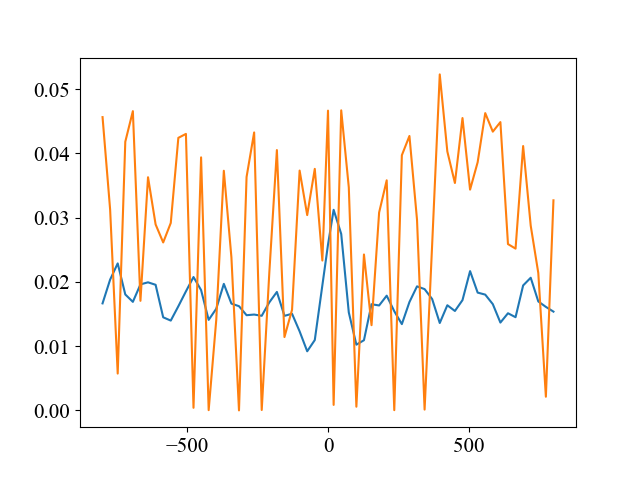

In [4]:
# Not kinematics version
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.05,
    # 'batch_size': 512, # Number of windows estimator processes at any time
    's_per_batch': 25, # Alternatively specify seconds of data a batch should be
    'learning_rate': 5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 10, # Number of epochs until random shifting is at max
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 4,
    'hidden_dim': 256,
    'embed_dim': 10,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))
time_shifts = np.concatenate([np.linspace(-0.8, -0.02, 30), np.array([0]), np.linspace(0.02, 0.8, 30)])

# Train, then time shift
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), 
    window_size=params['window_size'], neuron_label_filter=1, 
    select_x=[12], select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm'])
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=False)
model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
mi_inference = np.zeros_like(time_shifts)
with torch.no_grad():
    ds.move_data_to_windows(time_offset=0)
    for i,shift in enumerate(time_shifts):
        ds.time_shift(shift, X='X')
        mi_inference[i] = - model(ds.X, ds.Y).detach().cpu().numpy()

# Train at each
mi_train = np.zeros_like(time_shifts)
for i,shift in enumerate(time_shifts):
    ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), 
        window_size=params['window_size'], neuron_label_filter=1, 
        select_x=[12], select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm'])
    ds.time_shift(shift, X='X')
    this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
    mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=False)
    model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
    with torch.no_grad():
        ds.move_data_to_windows(time_offset=0)
        mi_train[i] = - model(ds.X, ds.Y).detach().cpu().numpy()


plt.figure()
plt.plot(time_shifts * 1000, mi_inference)
plt.plot(time_shifts * 1000, mi_train)
plt.show()

Early stopping triggered after 158 epochs. Best estimator_ts: 0.4997303783893585
Early stopping triggered after 221 epochs. Best estimator_ts: 0.29833611845970154
Early stopping triggered after 206 epochs. Best estimator_ts: 0.5305267572402954
Early stopping triggered after 168 epochs. Best estimator_ts: 0.3410511314868927
Early stopping triggered after 194 epochs. Best estimator_ts: 0.39693593978881836
Early stopping triggered after 254 epochs. Best estimator_ts: 0.5181626677513123
Early stopping triggered after 173 epochs. Best estimator_ts: 0.3673395812511444
Early stopping triggered after 167 epochs. Best estimator_ts: 0.526233434677124
Early stopping triggered after 132 epochs. Best estimator_ts: 0.3827974200248718
Early stopping triggered after 99 epochs. Best estimator_ts: 0.306560218334198
Early stopping triggered after 245 epochs. Best estimator_ts: 0.44188404083251953
Early stopping triggered after 183 epochs. Best estimator_ts: 0.29490771889686584
Early stopping triggered af

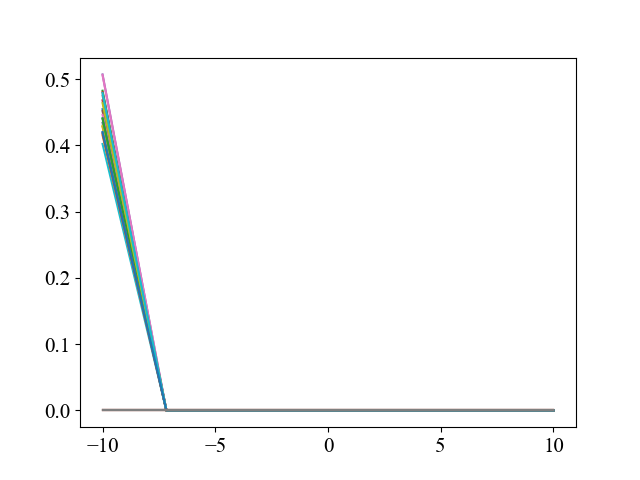

In [ ]:
# Not kinematics version
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.05,
    # 'batch_size': 512, # Number of windows estimator processes at any time
    's_per_batch': 25, # Alternatively specify seconds of data a batch should be
    'learning_rate': 5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 10, # Number of epochs until random shifting is at max
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 4,
    'hidden_dim': 256,
    'embed_dim': 10,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))
time_shifts = np.concatenate([-np.logspace(np.log10(0.01), np.log10(0.0005), 10), np.array([0]), np.logspace(np.log10(0.0005), np.log10(0.01), 10)])

ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-12_1'), window_size=params['window_size'])
neuron_labels = [ds.neuron_labels[i] for i in range(len(ds.neuron_labels)) if ds.neuron_quality[i] == 1]

# mi_inference = [np.zeros_like(time_shifts) for _ in neuron_labels]
mi_train = [np.zeros_like(time_shifts) for _ in neuron_labels]

# Train, then time shift, for all neurons
for i,n in enumerate(neuron_labels[0:1]):
    # ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-12_1'), window_size=params['window_size'], 
    #     select_x=[neuron_labels[i]])#, select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm'])
    # this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
    # mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=False)
    # model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
    # with torch.no_grad():
    #     ds.move_data_to_windows(time_offset=0)
    #     for si,shift in enumerate(time_shifts):
    #         ds.time_shift(shift, X='X')
    #         mi_inference[i][si] = - model(ds.X, ds.Y).detach().cpu().numpy()
    # mi_train = np.zeros_like(time_shifts)
    for si,shift in enumerate(time_shifts):
        ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-12_1'), 
            window_size=params['window_size'],
            select_x=[neuron_labels[i]], select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm'])
        ds.time_shift(shift, X='X')
        this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
        mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=False)
        model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
        with torch.no_grad():
            ds.move_data_to_windows(time_offset=0)
            mi_train[i][si] = - model(ds.X, ds.Y).detach().cpu().numpy()


plt.figure()
for i in range(len(neuron_labels)):
    # plt.plot(time_shifts * 1000, mi_inference[i])
    plt.plot(time_shifts * 1000, mi_train[i])
plt.show()

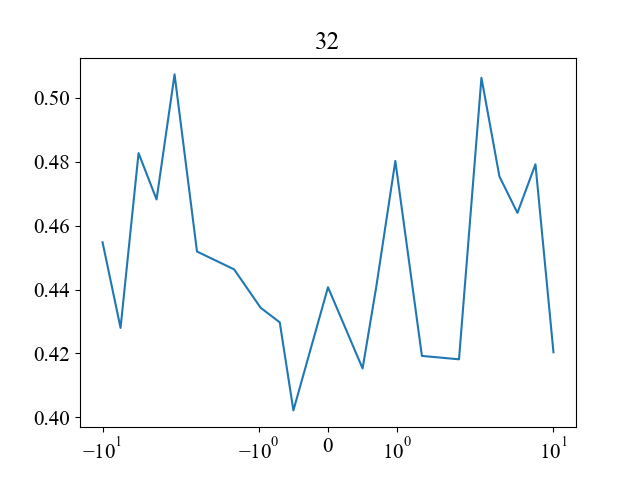

In [147]:
plt.figure()
# for i in range(len(neuron_labels)):
    # plt.plot(time_shifts * 1000, mi_inference[i])
i = 0
# plt.plot(time_shifts * 1000, mi_inference[i] / mi_inference[i].max())
# plt.plot(time_shifts * 1000, mi_inference[i] / mi_inference[i][30])
plt.plot(time_shifts * 1000, mi)
plt.gca().set_xscale('symlog')
plt.title(ds.neuron_labels[i])
plt.show()

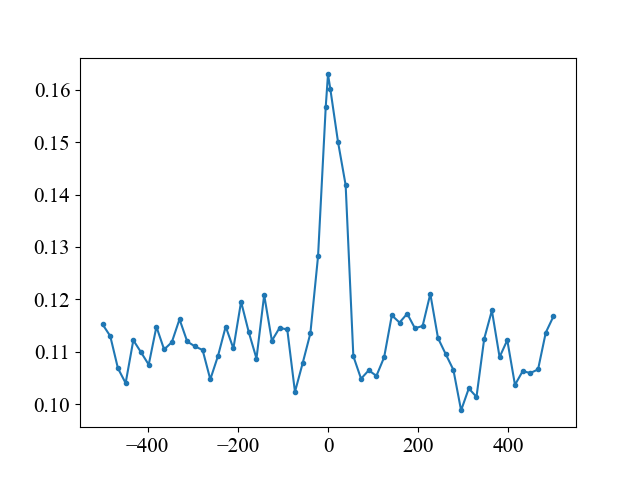

'7'

In [55]:
i = 11
plt.figure()
plt.plot(time_shifts * 1000, mi_inference[i], '.-')
plt.show()
ds.neuron_labels[i]

# Do I get the same MI from a trained model when I shift the window? 
# What do embeddings look like?

Epoch: 1, DSIB, test: 0.08351261168718338
Epoch: 2, DSIB, test: 0.08109027147293091
Epoch: 3, DSIB, test: 0.12202168256044388
Epoch: 4, DSIB, test: 0.24995313584804535
Epoch: 5, DSIB, test: 0.30402871966362
Epoch: 6, DSIB, test: 0.24037803709506989
Epoch: 7, DSIB, test: 0.2875445485115051
Epoch: 8, DSIB, test: 0.3470306992530823
Epoch: 9, DSIB, test: 0.37275785207748413
Epoch: 10, DSIB, test: 0.4037508964538574
Epoch: 11, DSIB, test: 0.288430780172348
Epoch: 12, DSIB, test: 0.4440784752368927
Epoch: 13, DSIB, test: 0.39935794472694397
Epoch: 14, DSIB, test: 0.46560701727867126
Epoch: 15, DSIB, test: 0.49204179644584656
Epoch: 16, DSIB, test: 0.49983757734298706
Epoch: 17, DSIB, test: 0.5985199809074402
Epoch: 18, DSIB, test: 0.5810480117797852
Epoch: 19, DSIB, test: 0.48693379759788513
Epoch: 20, DSIB, test: 0.6395593285560608
Epoch: 21, DSIB, test: 0.5201326608657837
Epoch: 22, DSIB, test: 0.7144821286201477
Epoch: 23, DSIB, test: 0.6201747059822083
Epoch: 24, DSIB, test: 0.6387159228

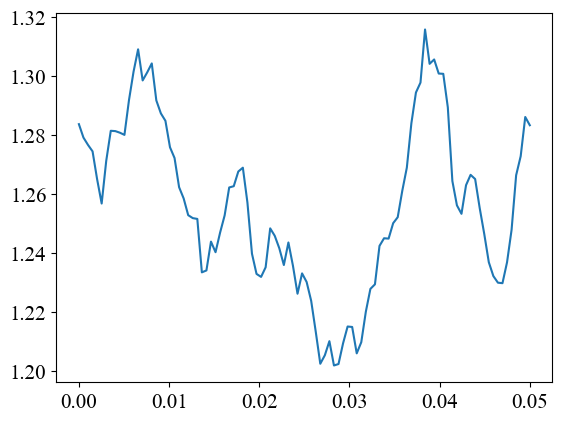

In [19]:
# Not kinematics version
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.05,
    'batch_size': 1024, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 20, # Number of epochs until random shifting is at max
    'start_shifting_epoch': 10,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 4,
    'hidden_dim': 128,
    'embed_dim': 6,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))
time_shifts = np.linspace(0, params['window_size'], 100)
empty_cache()

# Train, then time shift
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-12_1'), 
    window_size=params['window_size'], 
    select_x=['33'], select_y=['lax', 'lba', 'lsa', 'ldvm', 'ldlm', 'rdlm', 'rdvm', 'rsa', 'rba', 'rax'],
    use_ISI=False, use_phase=True)
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)

mi = np.zeros_like(time_shifts)
embed_x, embed_y, window_times = [], [], []
with torch.no_grad():
    for i in range(len(time_shifts)):
        ds.move_data_to_windows(time_offset=time_shifts[i])
        window_times.append(ds.window_times[ds.valid_windows])
        mi[i] = - model(ds.X, ds.Y).detach().cpu().numpy()
        # Get X and Y embeddings for dataset at this time shift
        batch_size = ds.X.shape[0]
        zX = torch.zeros(batch_size, this_params['embed_dim'], device=ds.X.device)
        zY = torch.zeros(batch_size, this_params['embed_dim'], device=ds.X.device)
        for i in range(0, batch_size, this_params['max_n_batches']):
            end_idx = min(i + this_params['max_n_batches'], batch_size)
            zX[i:end_idx,:] = model.encoder_x(ds.X[i:end_idx,:,:])
            zY[i:end_idx,:] = model.encoder_y(ds.Y[i:end_idx,:,:])
        embed_x.append(zX.detach().cpu().numpy())
        embed_y.append(zY.detach().cpu().numpy())

plt.figure()
plt.plot(time_shifts, mi)
plt.show()

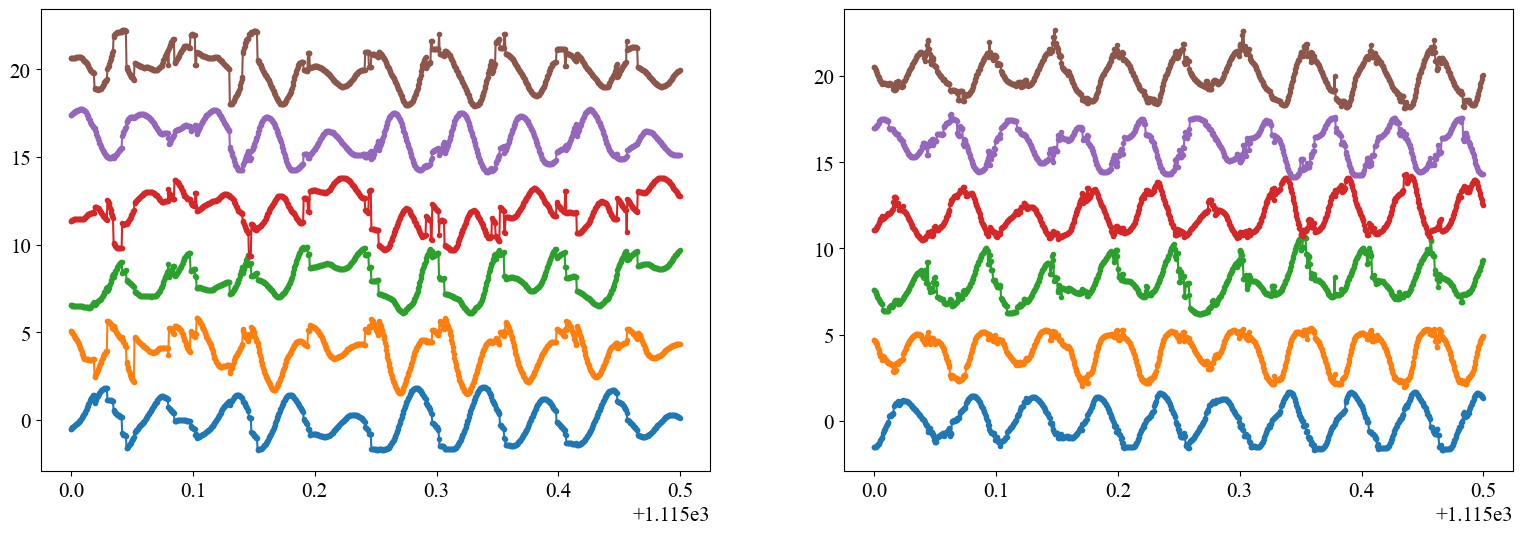

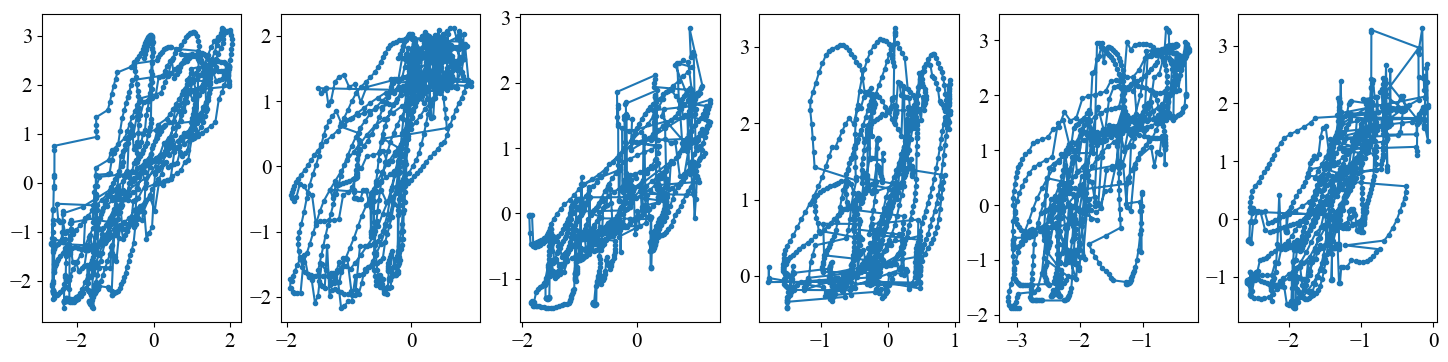

In [20]:
def assemble_embeddings(window_times, embed_x, embed_y):
    all_times = np.concatenate(window_times)
    shift_indices = np.concatenate([np.repeat(i, window_times[i].shape[0]) for i in range(len(window_times))])
    inds = np.argsort(all_times)
    vals_x = np.concatenate(embed_x)[inds]
    vals_y = np.concatenate(embed_y)[inds]
    return all_times[inds], vals_x, vals_y

times, ex, ey = assemble_embeddings(window_times, embed_x, embed_y)

fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(19,6))
stime = 1115
mask = np.logical_and(times > stime, times < stime+0.5)
for i in range(ex.shape[1]):
    xval = (ex[mask,i] - np.mean(ex[mask,i])) / np.std(ex[mask,i])
    yval = (ey[mask,i] - np.mean(ey[mask,i])) / np.std(ey[mask,i])
    ax[0].plot(times[mask], xval + 4*i, '.-')
    ax[1].plot(times[mask], yval + 4*i, '.-')
plt.show()
fig, ax = plt.subplots(1, ex.shape[1], sharex=False, sharey=False, figsize=(18,4))
for i in range(ex.shape[1]):
    ax[i].plot(ex[mask,i], ey[mask,i], '.-')
plt.show()

## What does noise corruption look like in embedding space?

Epoch: 1, DSIB, test: -0.3310011923313141
Epoch: 2, DSIB, test: -0.002060125581920147
Epoch: 3, DSIB, test: -3.3818923839135095e-06
Epoch: 4, DSIB, test: -0.06215735152363777
Epoch: 5, DSIB, test: -0.08210470527410507
Epoch: 6, DSIB, test: -0.09243616461753845
Epoch: 7, DSIB, test: -0.06075812503695488
Epoch: 8, DSIB, test: -0.028798863291740417
Epoch: 9, DSIB, test: -0.037023432552814484
Epoch: 10, DSIB, test: -0.051636241376399994
Epoch: 11, DSIB, test: -0.038025058805942535
Epoch: 12, DSIB, test: -0.025966674089431763
Epoch: 13, DSIB, test: -0.011004293337464333
Epoch: 14, DSIB, test: -0.0217157993465662
Epoch: 15, DSIB, test: -0.010320300236344337
Epoch: 16, DSIB, test: -0.02689382992684841
Epoch: 17, DSIB, test: -0.015861649066209793
Epoch: 18, DSIB, test: -0.026956988498568535
Epoch: 19, DSIB, test: -0.024502934888005257
Epoch: 20, DSIB, test: -0.03384452685713768
Epoch: 21, DSIB, test: -0.01678873598575592
Epoch: 22, DSIB, test: -0.006824046839028597
Epoch: 23, DSIB, test: -0.01

AttributeError: 'list' object has no attribute 'shape'

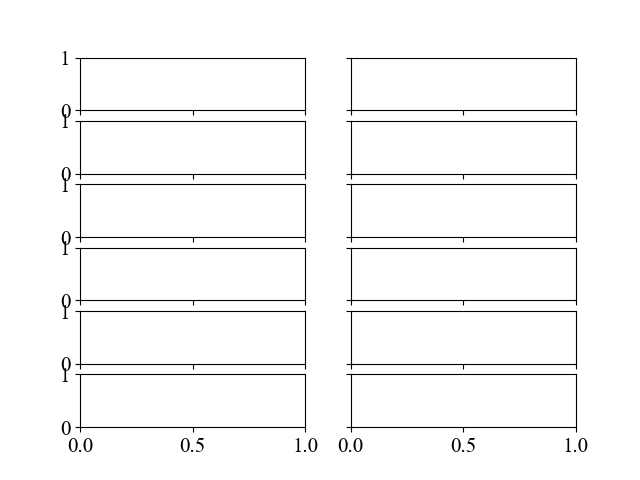

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.05,
    'batch_size': 512, # Number of windows estimator processes at any time
    # 's_per_batch': 5, # Alternatively specify seconds of data a batch should be
    'learning_rate': 5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 10, # Number of epochs until random shifting is at max
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 4,
    'hidden_dim': 512,
    'embed_dim': 2,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}

def assemble_embeddings(window_times, embed_x, embed_y):
    all_times = np.concatenate(window_times)
    shift_indices = np.concatenate([np.repeat(i, window_times[i].shape[0]) for i in range(len(window_times))])
    inds = np.argsort(all_times)
    vals_x = np.concatenate(embed_x)[inds]
    vals_y = np.concatenate(embed_y)[inds]
    return all_times[inds], vals_x, vals_y

prec_range = np.array([0, 0.01])

def train_and_get_embeddings(window_size):
    time_shifts = np.linspace(0, window_size, 100)
    ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), 
        window_size=window_size, neuron_label_filter=1, 
        select_x=[10], select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm']
    )
    this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
    mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
    model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)

    times, ex, ey = [], [], []
    for pi, prec in enumerate(prec_range):
        mi = np.zeros_like(time_shifts)
        embed_x, embed_y, window_times = [], [], []
        with torch.no_grad():
            for i in range(len(time_shifts)):
                ds.move_data_to_windows(time_offset=time_shifts[i])
                if prec != 0:
                    ds.apply_precision(prec, 'X')
                window_times.append(ds.window_times[ds.valid_windows])
                mi[i] = - model(ds.X, ds.Y).detach().cpu().numpy()
                # Get X and Y embeddings for dataset at this time shift
                batch_size = ds.X.shape[0]
                zX = torch.zeros(batch_size, this_params['embed_dim'], device=ds.X.device)
                zY = torch.zeros(batch_size, this_params['embed_dim'], device=ds.X.device)
                for i in range(0, batch_size, this_params['max_n_batches']):
                    end_idx = min(i + this_params['max_n_batches'], batch_size)
                    zX[i:end_idx,:] = model.encoder_x(ds.X[i:end_idx,:,:])
                    zY[i:end_idx,:] = model.encoder_y(ds.Y[i:end_idx,:,:])
                embed_x.append(zX.detach().cpu().numpy())
                embed_y.append(zY.detach().cpu().numpy())
        thistimes, thisex, thisey = assemble_embeddings(window_times, embed_x, embed_y)
        times.append(thistimes)
        ex.append(thisex)
        ey.append(thisey)
    return times, ex, ey

window_size_range = np.array([0.02, 0.05, 0.1])

# Look at embeddings over time
times, ex, ey = [], [], []
for wi,window in enumerate(window_size_range):
    ttimes, tex, tey = train_and_get_embeddings(window)
    times.append(ttimes)
    ex.append(tex)
    ey.append(tey)

fig, ax = plt.subplots(len(prec_range) * len(window_size_range), 2, sharex=True, sharey=True)
for wi,window in enumerate(window_size_range):
    for pi, prec in enumerate(prec_range):
        for i in range(ex[wi][pi].shape[1]):
            xval = (ex[wi][pi][:,i] - np.mean(ex[wi][pi][:,i])) / np.std(ex[wi][pi][:,i])
            yval = (ey[wi][pi][:,i] - np.mean(ey[wi][pi][:,i])) / np.std(ey[wi][pi][:,i])
            ax[2*wi + pi,0].plot(times[wi][pi], xval + 4*i, '.-')
            ax[2*wi + pi,1].plot(times[wi][pi], yval + 4*i, '.-')
plt.show()

In [11]:
fig, ax = plt.subplots(len(prec_range) * len(window_size_range), 2, sharex=True, sharey=True)
for wi,window in enumerate(window_size_range):
    for pi, prec in enumerate(prec_range):
        for i in range(ex[wi][pi].shape[1]):
            xval = (ex[wi][pi][:,i] - np.mean(ex[wi][pi][:,i])) / np.std(ex[wi][pi][:,i])
            yval = (ey[wi][pi][:,i] - np.mean(ey[wi][pi][:,i])) / np.std(ey[wi][pi][:,i])
            ax[2*wi + pi,0].plot(times[wi][pi], xval + 4*i, '.-')
            ax[2*wi + pi,1].plot(times[wi][pi], yval + 4*i, '.-')
# fig, ax = plt.subplots(len(window_size_range), 2, sharex=True, sharey=True)
# for wi,window in enumerate(window_size_range):
#     for pi, prec in enumerate(prec_range):
#         # for i in range(ex[wi][pi].shape[1]):
#         mask = np.logical_and(times[wi][pi] > 912.2, times[wi][pi] < 912.6)
#         xval = (ex[wi][pi][mask,0] - np.mean(ex[wi][pi][:,0])) / np.std(ex[wi][pi][:,0])
#         yval = (ey[wi][pi][mask,0] - np.mean(ey[wi][pi][:,0])) / np.std(ey[wi][pi][:,0])
#         ax[wi,pi].plot(xval, yval, '.-')
plt.show()

NameError: name 'prec_range' is not defined

# Revisit applying noise vs rounding

Epoch: 1, DSIB, test: 0.00013490859419107437
Epoch: 2, DSIB, test: 0.005880329757928848
Epoch: 3, DSIB, test: 0.001662498340010643
Epoch: 4, DSIB, test: 0.006261033937335014
Epoch: 5, DSIB, test: 0.003562420606613159
Epoch: 6, DSIB, test: 0.00895649939775467
Epoch: 7, DSIB, test: 0.006744638085365295
Epoch: 8, DSIB, test: 0.003595653921365738
Epoch: 9, DSIB, test: -0.004120957106351852
Epoch: 10, DSIB, test: 0.00521024689078331
Epoch: 11, DSIB, test: 0.006900599226355553
Epoch: 12, DSIB, test: 0.009159475564956665
Epoch: 13, DSIB, test: 0.003500383347272873
Epoch: 14, DSIB, test: 0.009382877498865128
Epoch: 15, DSIB, test: 0.007712453603744507
Epoch: 16, DSIB, test: -0.0022678226232528687
Epoch: 17, DSIB, test: 0.0045858025550842285
Epoch: 18, DSIB, test: 0.003709733486175537
Epoch: 19, DSIB, test: 0.007361520081758499
Epoch: 20, DSIB, test: 0.006758835166692734
Epoch: 21, DSIB, test: 0.002540241926908493
Epoch: 22, DSIB, test: -0.00642414391040802
Epoch: 23, DSIB, test: 0.008642777800

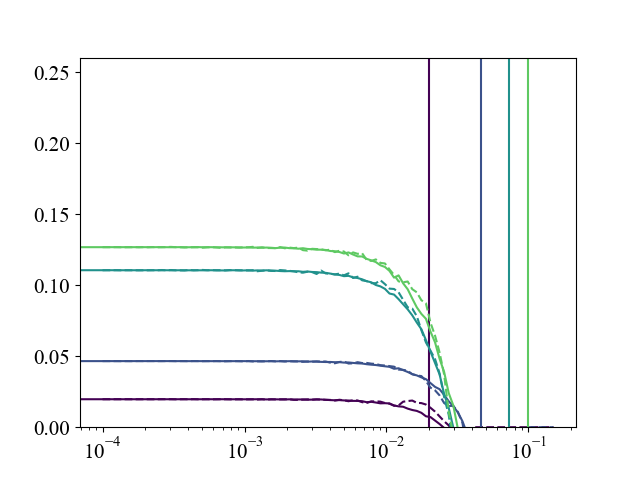

In [10]:
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.05,
    'batch_size': 512, # Number of windows estimator processes at any time
    # 's_per_batch': 5, # Alternatively specify seconds of data a batch should be
    'learning_rate': 5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 4, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 20, # Number of epochs until random shifting is at max
    'start_shifting_epoch': 10,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 4,
    'hidden_dim': 128,
    'embed_dim': 10,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))
time_shifts = np.linspace(0, params['window_size'], 100)

window_size_range = np.linspace(0.02, 0.1, 4)

cmap = plt.cm.viridis
fig, ax = plt.subplots()
ax.set_xscale('log')

for wi, window_size in enumerate(window_size_range):
    # Train, then time shift
    ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-20'), 
        window_size=window_size, 
        select_x=['6'], 
        select_y=['ldlm'], 
        # select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm'], 
        use_ISI=False
    )
    this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
    mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
    model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)

    ds.move_data_to_windows(0)

    with torch.no_grad():
        # Precision on ISI
        mi_isi = np.zeros_like(precision_levels)
        mi_noise = np.zeros((len(precision_levels), 10))
        for i,prec in enumerate(precision_levels):
            ds.apply_precision(prec)
            mi_isi[i] = - model(ds.X, ds.Y).detach().cpu().numpy()
            for j in range(10):
                ds.apply_noise(prec)
                mi_noise[i,j] = - model(ds.X, ds.Y).detach().cpu().numpy()
    
    ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-20'), 
        window_size=window_size, 
        select_x=['6'], 
        select_y=['ldlm'], 
        # select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm'], 
        use_ISI=False
    )
    i = 0
    meanfirstISI = np.mean(ds.X[ds.X[:, 0, i].nonzero(), 0, i].cpu().numpy())
    ind = np.argmax(mi_noise.mean(axis=1) <= 0)
    reachzeropoint = precision_levels[ind]
    ind = np.argmax(mi_isi <= 0)
    reachzeropoint_round = precision_levels[ind]
    print(f'mean first ISI: {meanfirstISI}')
    print(f'noise at which zero is reached: {reachzeropoint}')
    print(f'Rounding at which zero is reached: {reachzeropoint_round}')

    col = cmap(wi/len(window_size_range))
    plt.plot(precision_levels, mi_isi, '--', color=col)
    plt.plot(precision_levels, mi_noise.mean(axis=1), '-', color=col)
    plt.axvline(window_size, color=col)
    
ax.set_ylim(0)
plt.show()


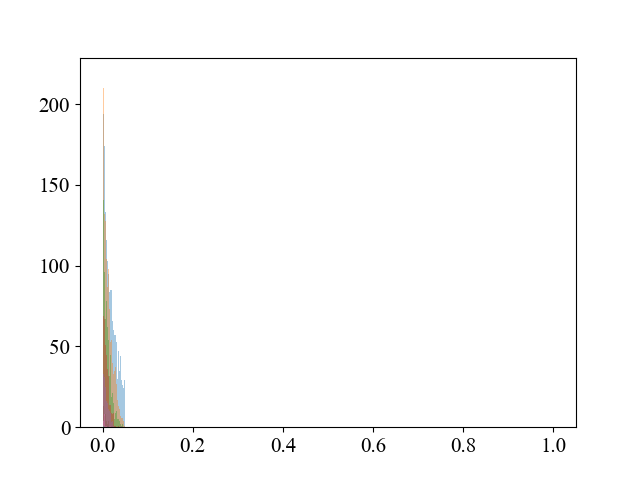

In [56]:
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-20'), 
    window_size=params['window_size'], neuron_label_filter=1, 
    select_x=['38'], select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm'])


plt.figure()
for i in range(ds.X.shape[2]):
    plt.hist(ds.X[ds.X[:, 0, i].nonzero(), 0, i].cpu().numpy(), bins=100, alpha=0.4)
plt.show()

# Train networks with ISI only (first spike just typical ISI) compared to offset first spike

Epoch: 1, DSIB, test: 0.07609867304563522
Epoch: 2, DSIB, test: 0.1215236708521843
Epoch: 3, DSIB, test: 0.12771114706993103
Epoch: 4, DSIB, test: 0.12664063274860382
Epoch: 5, DSIB, test: 0.10631223022937775
Epoch: 6, DSIB, test: 0.11664746701717377
Epoch: 7, DSIB, test: 0.13033923506736755
Epoch: 8, DSIB, test: 0.16488485038280487
Epoch: 9, DSIB, test: 0.13916105031967163
Epoch: 10, DSIB, test: 0.19611424207687378
Epoch: 11, DSIB, test: 0.20004193484783173
Epoch: 12, DSIB, test: 0.20815473794937134
Epoch: 13, DSIB, test: 0.20486003160476685
Epoch: 14, DSIB, test: 0.2392931431531906
Epoch: 15, DSIB, test: 0.20975731313228607
Epoch: 16, DSIB, test: 0.22414112091064453
Epoch: 17, DSIB, test: 0.23064884543418884
Epoch: 18, DSIB, test: 0.161871075630188
Epoch: 19, DSIB, test: 0.18927520513534546
Epoch: 20, DSIB, test: 0.1903841346502304
Epoch: 21, DSIB, test: 0.23491691052913666
Epoch: 22, DSIB, test: 0.2205037772655487
Epoch: 23, DSIB, test: 0.21004100143909454
Epoch: 24, DSIB, test: 0.2

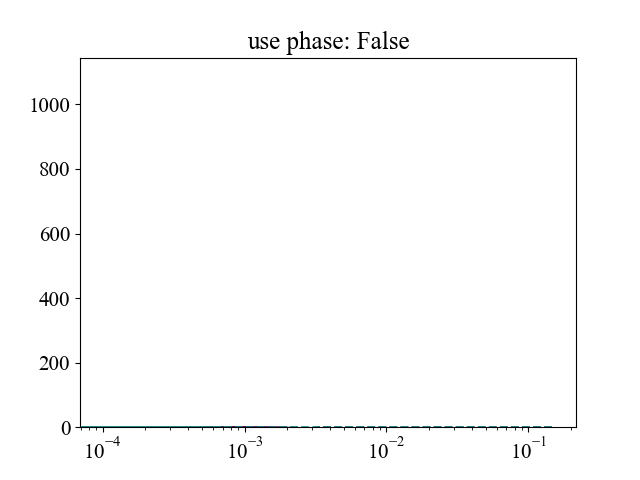

Epoch: 1, DSIB, test: 0.11112228780984879
Epoch: 2, DSIB, test: 0.13784554600715637
Epoch: 3, DSIB, test: 0.14577774703502655
Epoch: 4, DSIB, test: 0.15069225430488586
Epoch: 5, DSIB, test: 0.14341852068901062
Epoch: 6, DSIB, test: 0.18780682981014252
Epoch: 7, DSIB, test: 0.16042594611644745
Epoch: 8, DSIB, test: 0.16728390753269196
Epoch: 9, DSIB, test: 0.220741406083107
Epoch: 10, DSIB, test: 0.19977566599845886
Epoch: 11, DSIB, test: 0.22328299283981323
Epoch: 12, DSIB, test: 0.1485797017812729
Epoch: 13, DSIB, test: 0.2085089236497879
Epoch: 14, DSIB, test: 0.20157194137573242
Epoch: 15, DSIB, test: 0.25064384937286377
Epoch: 16, DSIB, test: 0.23421145975589752
Epoch: 17, DSIB, test: 0.18757376074790955
Epoch: 18, DSIB, test: 0.22789955139160156
Epoch: 19, DSIB, test: 0.15846748650074005
Epoch: 20, DSIB, test: 0.14714616537094116
Epoch: 21, DSIB, test: 0.2634694576263428
Epoch: 22, DSIB, test: 0.26625460386276245
Epoch: 23, DSIB, test: 0.2641509473323822
Epoch: 24, DSIB, test: 0.2

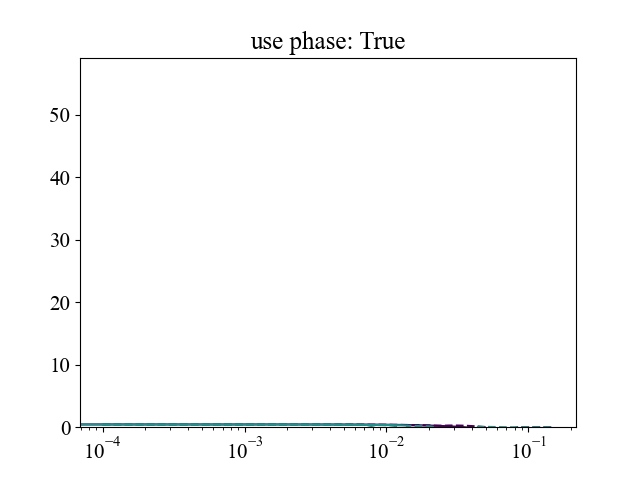

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.04,
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'patience': 100,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 4, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 50, # Number of epochs until random shifting is at max
    'start_shifting_epoch': 10,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 4,
    'hidden_dim': 128,
    'embed_dim': 10,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))
time_shifts = np.linspace(0, params['window_size'], 100)

window_size_range = np.linspace(0.02, 0.1, 4)

cmap = plt.cm.viridis

for phase_i, use_phase in enumerate([False, True]):
    fig, ax = plt.subplots()
    ax.set_xscale('log')
    ax.set_title(f'use phase: {use_phase}')
    for wi, useISIoffset in enumerate([False, True]):
        # Train, then time shift
        ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-20'), 
            window_size=params['window_size'], 
            select_x=['58'], 
            use_ISI=useISIoffset,
            use_phase=use_phase
            # select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm'], 
            )
        this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
        mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
        model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
        with torch.no_grad():
            print(- model(ds.X, ds.Y).detach().cpu().numpy())
        ds.move_data_to_windows(0)
        with torch.no_grad():
            print(- model(ds.X, ds.Y).detach().cpu().numpy())

        with torch.no_grad():
            # Precision on ISI
            mi_isi = np.zeros_like(precision_levels)
            mi_noise = np.zeros((len(precision_levels), 10))
            for i,prec in enumerate(precision_levels):
                prec /= ds.window_size
                ds.apply_precision(prec)
                mi_isi[i] = - model(ds.X, ds.Y).detach().cpu().numpy()
                for j in range(10):
                    ds.apply_noise(prec)
                    mi_noise[i,j] = - model(ds.X, ds.Y).detach().cpu().numpy()
        
        ds.apply_noise(0)
        i = 0
        meanfirstISI = np.mean(ds.X[ds.X[:, 0, i].nonzero(), 0, i].cpu().numpy())
        ind = np.argmax(mi_noise.mean(axis=1) <= 0)
        reachzeropoint = precision_levels[ind]
        ind = np.argmax(mi_isi <= 0)
        reachzeropoint_round = precision_levels[ind]
        print(f'mean first ISI: {meanfirstISI}')
        print(f'noise at which zero is reached: {reachzeropoint}')
        print(f'Rounding at which zero is reached: {reachzeropoint_round}')

        col = cmap(wi/2)
        plt.plot(precision_levels, mi_isi, '--', color=col)
        plt.plot(precision_levels, mi_noise.mean(axis=1), '-', color=col)
    
    ax.set_ylim(0)
    plt.show()


Epoch: 1, DSIB, test: 0.023372212424874306
Epoch: 2, DSIB, test: 0.026091359555721283
Epoch: 3, DSIB, test: 0.037377215921878815
Epoch: 4, DSIB, test: 0.03872368112206459
Epoch: 5, DSIB, test: 0.03910655528306961
Epoch: 6, DSIB, test: 0.04352657124400139
Epoch: 7, DSIB, test: 0.02668604627251625
Epoch: 8, DSIB, test: 0.04737386107444763
Epoch: 9, DSIB, test: 0.028779486194252968
Epoch: 10, DSIB, test: 0.03773970901966095
Epoch: 11, DSIB, test: 0.04509840905666351
Epoch: 12, DSIB, test: 0.03747263550758362
Epoch: 13, DSIB, test: 0.044662583619356155
Epoch: 14, DSIB, test: 0.0074523743242025375
Epoch: 15, DSIB, test: 0.039957523345947266
Epoch: 16, DSIB, test: 0.024229321628808975
Epoch: 17, DSIB, test: 0.03891969844698906
Epoch: 18, DSIB, test: 0.040570955723524094
Epoch: 19, DSIB, test: 0.04201270267367363
Epoch: 20, DSIB, test: 0.027548305690288544
Epoch: 21, DSIB, test: 0.044612277299165726
Epoch: 22, DSIB, test: 0.044506192207336426
Epoch: 23, DSIB, test: 0.03358519449830055
Epoch: 

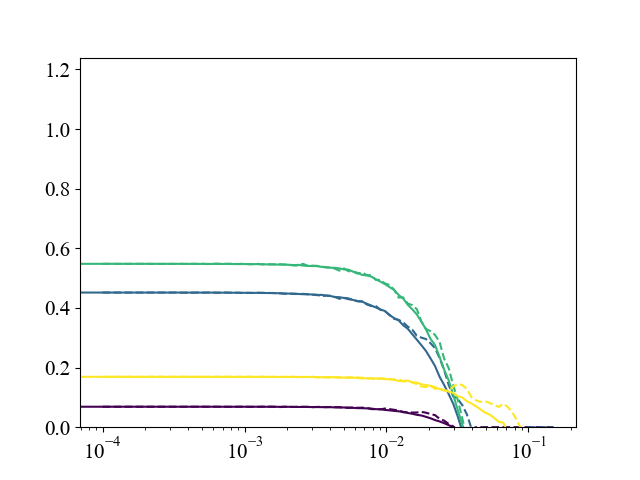

In [10]:
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.04,
    'batch_size': 512, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'patience': 100,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 4, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 50, # Number of epochs until random shifting is at max
    'start_shifting_epoch': 10,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 4,
    'hidden_dim': 128,
    'embed_dim': 10,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))
time_shifts = np.linspace(0, params['window_size'], 100)

window_size_range = np.linspace(0.02, 0.1, 4)

cmap = plt.cm.viridis

fig, ax = plt.subplots()
ax.set_xscale('log')
for wi, window_size in enumerate(window_size_range):
    # Train, then time shift
    ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-20'), 
        window_size=window_size, 
        select_x=['58'], 
        use_ISI=False,
        use_phase=True,
        select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm']
        )
    this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
    mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
    model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
    with torch.no_grad():
        print(- model(ds.X, ds.Y).detach().cpu().numpy())
    ds.move_data_to_windows(0)
    with torch.no_grad():
        print(- model(ds.X, ds.Y).detach().cpu().numpy())

    with torch.no_grad():
        # Precision on ISI
        mi_isi = np.zeros_like(precision_levels)
        mi_noise = np.zeros((len(precision_levels), 10))
        for i,prec in enumerate(precision_levels):
            prec /= ds.window_size
            ds.apply_precision(prec)
            mi_isi[i] = - model(ds.X, ds.Y).detach().cpu().numpy()
            for j in range(10):
                ds.apply_noise(prec)
                mi_noise[i,j] = - model(ds.X, ds.Y).detach().cpu().numpy()
    
    ds.apply_noise(0)

    col = cmap(wi/(len(window_size_range)-1))
    plt.plot(precision_levels, mi_isi, '--', color=col)
    plt.plot(precision_levels, mi_noise.mean(axis=1), '-', color=col)

ax.set_ylim(0)
plt.show()


Epoch: 1, DSIB, test: 0.03431379795074463
Epoch: 2, DSIB, test: 0.0058626472018659115
Epoch: 3, DSIB, test: 0.029070528224110603
Epoch: 4, DSIB, test: 0.025171739980578423
Epoch: 5, DSIB, test: 0.02759050764143467
Epoch: 6, DSIB, test: 0.027044154703617096
Epoch: 7, DSIB, test: 0.02458205632865429
Epoch: 8, DSIB, test: 0.01163200568407774
Epoch: 9, DSIB, test: 0.02107015997171402
Epoch: 10, DSIB, test: 0.020486116409301758
Epoch: 11, DSIB, test: 0.01816176064312458
Epoch: 12, DSIB, test: 0.009539521299302578
Epoch: 13, DSIB, test: 0.02226535975933075
Epoch: 14, DSIB, test: 0.022140441462397575
Epoch: 15, DSIB, test: 0.02453308179974556
Epoch: 16, DSIB, test: 0.020405983552336693
Epoch: 17, DSIB, test: 0.02569589763879776
Epoch: 18, DSIB, test: 0.019909439608454704
Epoch: 19, DSIB, test: 0.022197946906089783
Epoch: 20, DSIB, test: 0.02648475393652916
Epoch: 21, DSIB, test: 0.009749062359333038
Epoch: 22, DSIB, test: 0.026413610205054283
Epoch: 23, DSIB, test: 0.016767224296927452
Epoch:

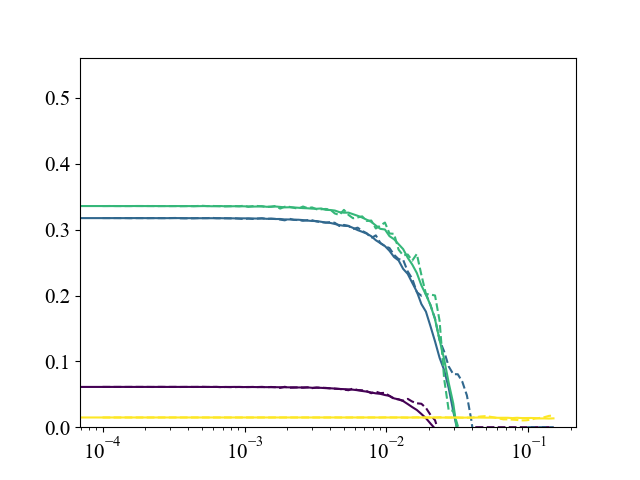

In [11]:
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.04,
    'batch_size': 512, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'patience': 100,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 4, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 50, # Number of epochs until random shifting is at max
    'start_shifting_epoch': 10,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.LeakyReLU,
    'layers': 4,
    'hidden_dim': 128,
    'embed_dim': 10,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))
time_shifts = np.linspace(0, params['window_size'], 100)

window_size_range = np.linspace(0.02, 0.1, 4)

cmap = plt.cm.viridis

fig, ax = plt.subplots()
ax.set_xscale('log')
for wi, window_size in enumerate(window_size_range):
    # Train, then time shift
    ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-20'), 
        window_size=window_size, 
        select_x=['58'], 
        use_ISI=False,
        use_phase=False,
        select_y=['ldvm', 'ldlm', 'rdlm', 'rdvm']
        )
    this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}
    mis_test, train_id = train_model_no_eval(ds, this_params, X='X', Y='Y', verbose=True)
    model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
    with torch.no_grad():
        print(- model(ds.X, ds.Y).detach().cpu().numpy())
    ds.move_data_to_windows(0)
    with torch.no_grad():
        print(- model(ds.X, ds.Y).detach().cpu().numpy())

    with torch.no_grad():
        # Precision on ISI
        mi_isi = np.zeros_like(precision_levels)
        mi_noise = np.zeros((len(precision_levels), 10))
        for i,prec in enumerate(precision_levels):
            # prec /= ds.window_size
            ds.apply_precision(prec)
            mi_isi[i] = - model(ds.X, ds.Y).detach().cpu().numpy()
            for j in range(10):
                ds.apply_noise(prec)
                mi_noise[i,j] = - model(ds.X, ds.Y).detach().cpu().numpy()
    
    ds.apply_noise(0)

    col = cmap(wi/(len(window_size_range)-1))
    plt.plot(precision_levels, mi_isi, '--', color=col)
    plt.plot(precision_levels, mi_noise.mean(axis=1), '-', color=col)

ax.set_ylim(0)
plt.show()

# Does precision change when looking at single muscles vs. all muscles?

Epoch: 1, DSIB, test: -0.006780412048101425
Epoch: 2, DSIB, test: 0.03418681398034096
Epoch: 3, DSIB, test: 0.019450196996331215
Epoch: 4, DSIB, test: 0.03732697665691376
Epoch: 5, DSIB, test: 0.0413975715637207
Epoch: 6, DSIB, test: 0.07327165454626083
Epoch: 7, DSIB, test: 0.0321558378636837
Epoch: 8, DSIB, test: -0.021032536402344704
Epoch: 9, DSIB, test: 0.11070013046264648
Epoch: 10, DSIB, test: -0.05498456582427025
Epoch: 11, DSIB, test: -0.07215887308120728
Epoch: 12, DSIB, test: 0.03557834029197693
Epoch: 13, DSIB, test: 0.05021379888057709
Epoch: 14, DSIB, test: -0.03354548290371895
Epoch: 15, DSIB, test: 0.1669679880142212
Epoch: 16, DSIB, test: 0.0333113819360733
Epoch: 17, DSIB, test: 0.0018859623232856393
Epoch: 18, DSIB, test: 0.06268644332885742
Epoch: 19, DSIB, test: 0.18511830270290375
Epoch: 20, DSIB, test: 0.10088595747947693
Epoch: 21, DSIB, test: -0.015031526796519756
Epoch: 22, DSIB, test: -0.07968448847532272
Epoch: 23, DSIB, test: 0.11251580715179443
Epoch: 24, 

(0.0, 0.8630065187811852)

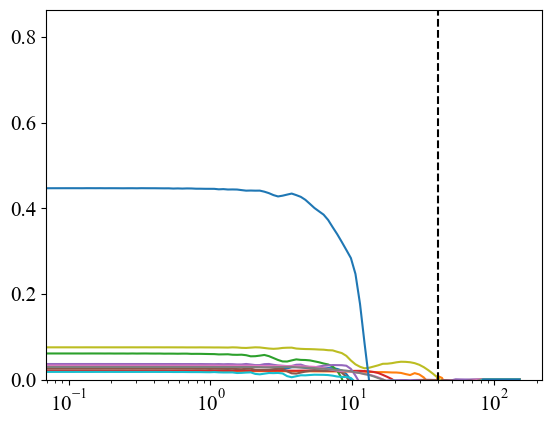

In [2]:
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.04,
    # 'batch_size': 512, # Number of windows estimator processes at any time
    's_per_batch': 25, # Alternatively specify seconds of data a batch should be
    'learning_rate': 5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 10, # Number of epochs until random shifting is at max
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.PReLU,
    'layers': 3,
    'hidden_dim': 1024,
    'embed_dim': 12,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))

# All muscles together
ds = TimeWindowDatasetKinematics(os.path.join(data_dir, '2025-02-25_1'), 
    window_size=params['window_size'], neuron_label_filter=1, 
    use_ISI=True, only_valid_kinematics=True, angles_only=True)
this_params = {**params, 'X_dim': ds.Y.shape[1] * ds.Y.shape[2], 'Y_dim': ds.Z.shape[1] * ds.Z.shape[2]}
mis_test, train_id = train_model_no_eval(ds, this_params, X='Y', Y='Z')
model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
mi_all = precision_rounding(precision_levels, ds, model, X='Y', Y='Z')
# Individual Muscles
mi = []
for i in range(10):
    ds = TimeWindowDatasetKinematics(os.path.join(data_dir, '2025-02-25_1'), 
        select_y=[i],
        window_size=params['window_size'], neuron_label_filter=1, 
        use_ISI=True, only_valid_kinematics=True, angles_only=True)
    this_params = {**params, 'X_dim': ds.Y.shape[1] * ds.Y.shape[2], 'Y_dim': ds.Z.shape[1] * ds.Z.shape[2]}
    mis_test, train_id = train_model_no_eval(ds, this_params, X='Y', Y='Z')
    model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
    mi.append(precision_rounding(precision_levels, ds, model, X='Y', Y='Z'))
    
    plt.plot(precision_levels * 1000, mi[i][1:])

plt.plot(precision_levels * 1000, mi_all[1:])
plt.axvline(this_params['window_size'] * 1000, color='k', linestyle='--')
plt.gca().set_xscale('log')
plt.gca().set_ylim(0)

(0.0, 0.6)

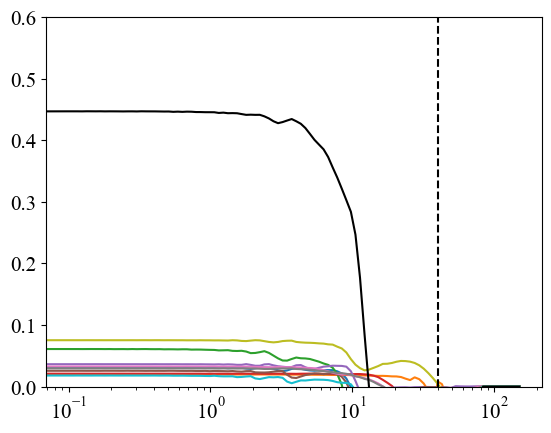

In [7]:

for i in range(10):
    # plt.plot(precision_levels * 1000, mi[i][1:] / mi[i][0])
    plt.plot(precision_levels * 1000, mi[i][1:])
# plt.plot(precision_levels * 1000, mi_all[1:] / mi_all[0], color='k')
plt.plot(precision_levels * 1000, mi_all[1:], color='k')
plt.axvline(this_params['window_size'] * 1000, color='k', linestyle='--')
plt.gca().set_xscale('log')
plt.gca().set_ylim(0, 0.6)

Epoch: 1, DSIB, test: 0.005901995114982128
Epoch: 2, DSIB, test: -0.020424991846084595
Epoch: 3, DSIB, test: -0.011384022422134876
Epoch: 4, DSIB, test: -0.006396844983100891
Epoch: 5, DSIB, test: 0.006019046064466238
Epoch: 6, DSIB, test: -0.03389984369277954
Epoch: 7, DSIB, test: -0.01702205277979374
Epoch: 8, DSIB, test: -0.00705272052437067
Epoch: 9, DSIB, test: -0.005090669263154268
Epoch: 10, DSIB, test: -0.00434656860306859
Epoch: 11, DSIB, test: -0.014588901773095131
Epoch: 12, DSIB, test: 0.0014322542119771242
Epoch: 13, DSIB, test: 0.006625804118812084
Epoch: 14, DSIB, test: -0.013557825237512589
Epoch: 15, DSIB, test: -0.0023385982494801283
Epoch: 16, DSIB, test: -0.01383969746530056
Epoch: 17, DSIB, test: 0.004565132316201925
Epoch: 18, DSIB, test: 0.013977142982184887
Epoch: 19, DSIB, test: 0.007846306078135967
Epoch: 20, DSIB, test: 0.008082780987024307
Epoch: 21, DSIB, test: 0.010419758036732674
Epoch: 22, DSIB, test: 0.021840348839759827
Epoch: 23, DSIB, test: -0.010258

(0.0, 0.22124315686523915)

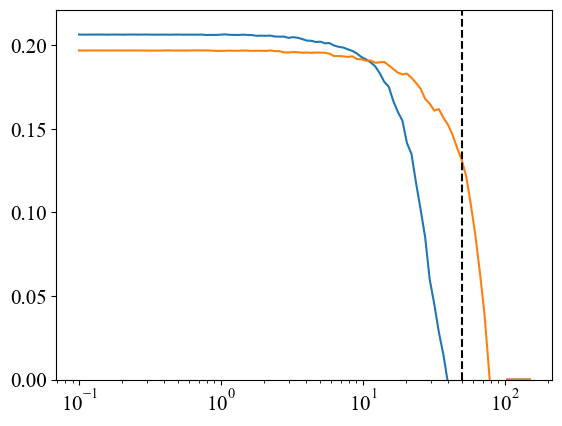

In [5]:
params = {
    # Optimizer parameters (for training)
    'epochs': 300,
    'window_size': 0.05,
    # 'batch_size': 512, # Number of windows estimator processes at any time
    's_per_batch': 30, # Alternatively specify seconds of data a batch should be
    'learning_rate': 5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.95,
    'n_test_set_blocks': 5, # Number of contiguous blocks of data to dedicate to test set
    'epochs_till_max_shift': 10, # Number of epochs until random shifting is at max
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'activation': nn.PReLU,
    'layers': 3,
    'hidden_dim': 128,
    'embed_dim': 6,
    'use_bias': False,
    'beta': 512, # Just used in DVSIB
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_levels = np.hstack((0, np.logspace(np.log10(0.0001), np.log10(0.15), 100)))

# ISI
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), window_size=params['window_size'], neuron_label_filter=1, use_ISI=True, select_x=[10])
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}

mis_test, train_id = train_model_no_eval(ds, this_params)
model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
mi = precision_rounding(precision_levels, ds, model)

# No ISI
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), window_size=params['window_size'], neuron_label_filter=1, use_ISI=False, select_x=[10])
this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2]}

mis_test, train_id = train_model_no_eval(ds, this_params)
model_reg = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)
mi_reg = precision_rounding(precision_levels, ds, model_reg)

plt.plot(precision_levels * 1000, mi[1:])
plt.plot(precision_levels * 1000, mi_reg[1:])
plt.axvline(this_params['window_size'] * 1000, color='k', linestyle='--')
plt.gca().set_xscale('log')
plt.gca().set_ylim(0)

(array([2., 0., 3., 1., 2., 1., 0., 0., 0., 1.]),
 array([1.10430193, 1.12148631, 1.13867056, 1.15585494, 1.17303932,
        1.19022369, 1.20740795, 1.22459233, 1.2417767 , 1.25896096,
        1.27614534]),
 <BarContainer object of 10 artists>)

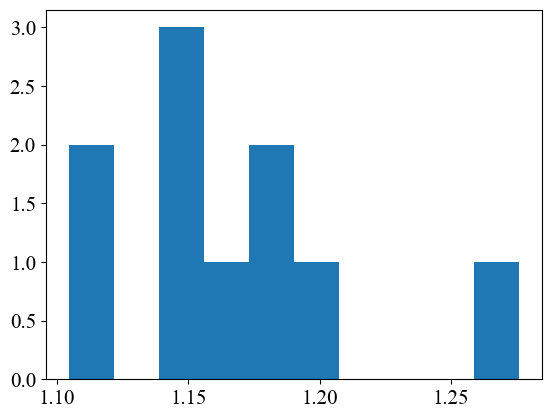

In [7]:
plt.hist(np.array(mi))

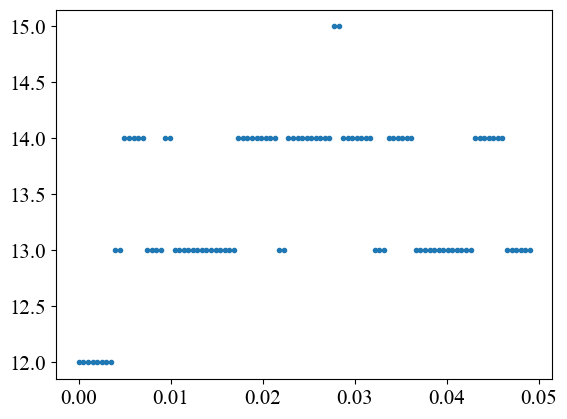

In [ ]:
offsets = np.linspace(0, 0.049, 100)
nwind = np.zeros_like(offsets)
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), window_size=0.05, neuron_label_filter=1, time_offset=0)
for i,off in enumerate(offsets):
    ds.move_data_to_windows(time_offset=off)
    # nwind[i] = ds.n_windows
    nwind[i] = ds.X.shape[2]
plt.plot(offsets, nwind, '.')

In [21]:
# Get normal precision curve
# precision_noise_levels = np.hstack((0, np.logspace(np.log10(0.002), np.log10(0.15), 40)))
precision_noise_levels = np.hstack((0, np.logspace(np.log10(2 * np.finfo(np.float32).eps), np.log10(0.15), 50)))
n_repeats = 3
precision_normal = precision(precision_noise_levels, ds, model, n_repeats=n_repeats)

# precision_levels = np.array([0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
# precision_levels = np.linspace(0.001, 0.15, 50)
prec_curves = []
for prec in precision_noise_levels:
    ds.move_data_to_windows()
    ds.apply_precision(prec)
    prec_curves.append(precision(precision_noise_levels, ds, model, n_repeats=n_repeats))

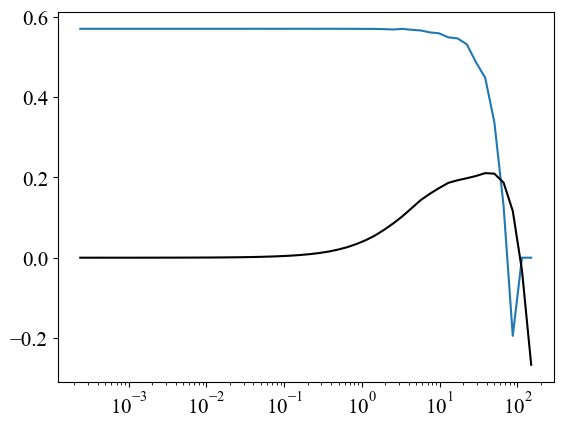

In [24]:
fig, ax = plt.subplots()
ax.plot(precision_noise_levels * 1000, np.array([p[0,:].mean() for p in prec_curves]))
ax.plot(precision_noise_levels[1:] * 1000, precision_normal[1:,:].mean(axis=1), color='k')
ax.set_xscale('log')

0.5417467355728149
expected - actual zero noise MI: -0.34018486738204956
0.437033474445343
expected - actual zero noise MI: -0.2219697137673696
0.21179932355880737
expected - actual zero noise MI: -0.0203293114900589
-0.07800589501857758
expected - actual zero noise MI: 0.19445889194806415
-0.02238442562520504
expected - actual zero noise MI: 0.13883742255469161
-6.41125623701555e-08
expected - actual zero noise MI: -0.025899744430861443


(0.0, 0.6012426982323329)

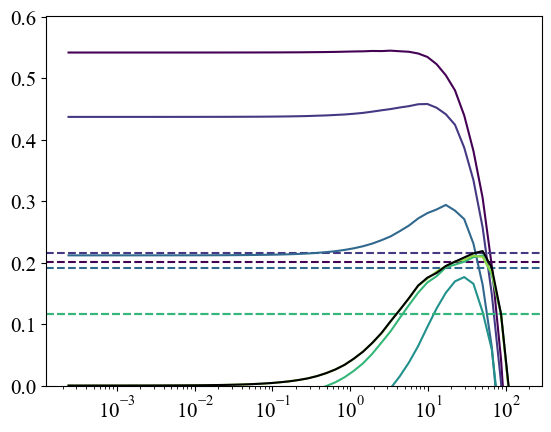

In [14]:
import matplotlib.cm as cm
cmap = plt.cm.viridis
fig, ax = plt.subplots()
for i, prec in enumerate(precision_levels):
    color = cmap(i/len(precision_levels))
    ax.plot(precision_noise_levels[1:] * 1000, prec_curves[i][1:,:].mean(axis=1), color=color)
    ind = np.argmin(np.abs(precision_noise_levels - prec))
    ax.axhline(precision_normal[ind,:].mean(), color=color, linestyle='--')
    print(prec_curves[i][0,:].mean())
    print(f'expected - actual zero noise MI: {precision_normal[ind,:].mean() - prec_curves[i][0,:].mean()}')
ax.plot(precision_noise_levels[1:] * 1000, precision_normal[1:,:].mean(axis=1), color='k')
ax.set_xscale('log')
ax.set_ylim(0)

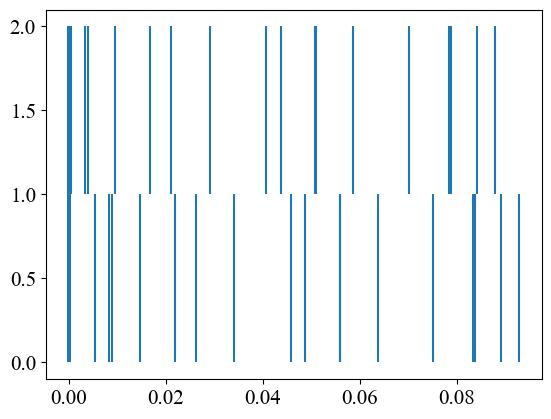

In [ ]:
ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), window_size=0.1, neuron_label_filter=1)
i = np.random.choice(ds.n_windows)
i = 0 
plt.vlines(ds.X[i,:,:].detach().cpu().numpy().flatten(), ymin=0, ymax=1)
ds.move_data_to_windows(time_offset=0.005)
# ds.apply_precision(0.001)
plt.vlines(ds.X[i,:,:].detach().cpu().numpy().flatten(), ymin=1, ymax=2)

In [58]:
precision_noise_levels = np.hstack((0, np.logspace(np.log10(0.002), np.log10(0.1), 30)))
n_repeats = 50

with torch.no_grad():
    synchronize()
    tic = time.time()
    mi = - model(ds.X, ds.Y).detach().cpu().numpy()
    synchronize()
    print(f'DSIB Inference: {time.time() - tic}')
    print(f'DSIB MI: {mi}')

    synchronize()
    tic = time.time()
    mi = model_DVSIB(ds.X, ds.Y)[2].detach().cpu().numpy()
    synchronize()
    print(f'DVSIB Inference: {time.time() - tic}')
    print(f'DVSIB MI: {mi}')

DSIB Inference: 0.029646873474121094
DSIB MI: 0.13518087565898895
DVSIB Inference: 0.06697607040405273
DVSIB MI: -0.0037905958015471697


Precision DSIB: 14.712713956832886, 0.009808475971221925 s/iteration


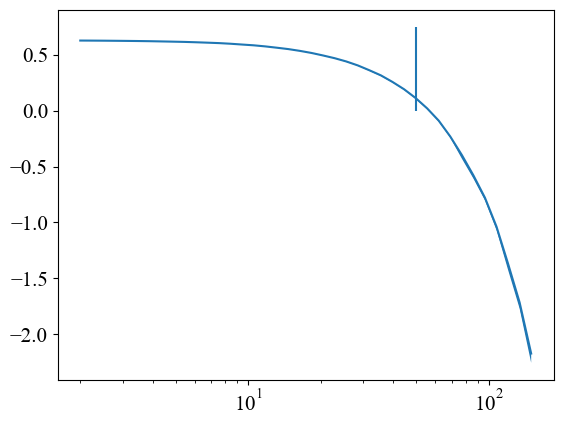

In [ ]:
precision_noise_levels = np.hstack((0, np.logspace(np.log10(0.002), np.log10(0.15), 40)))
n_repeats = 15

synchronize()
tic = time.time()
precision_mi = precision(precision_noise_levels, ds, model, n_repeats=n_repeats)
synchronize()
final_time = time.time() - tic
print(f'Precision DSIB: {final_time}, {final_time / 1500} s/iteration')

fig, ax = plt.subplots()
mean_sig, sd_sig = precision_mi[1:].mean(axis=1), precision_mi[1:].std(axis=1)
ax.plot(precision_noise_levels[1:] * 1000, mean_sig)
ax.fill_between(precision_noise_levels[1:] * 1000, mean_sig, mean_sig - sd_sig, mean_sig + sd_sig)
ax.vlines(0.05 * 1000, ymin=0, ymax=0.75)

# mean_sig, sd_sig = precision_mi_dvsib[1:].mean(axis=1), precision_mi_dvsib[1:].std(axis=1)
# ax.plot(precision_noise_levels[1:] * 1000, mean_sig)
# ax.fill_between(precision_noise_levels[1:] * 1000, mean_sig, mean_sig - sd_sig, mean_sig + sd_sig)
ax.set_xscale('log')

Epoch: 1, DSIB, test: 0.0010268732439726591
Epoch: 2, DSIB, test: 0.002406772691756487
Epoch: 3, DSIB, test: 0.006818594876676798
Epoch: 4, DSIB, test: 0.009204505011439323
Epoch: 5, DSIB, test: 0.009548758156597614
Epoch: 6, DSIB, test: 0.009588584303855896
Epoch: 7, DSIB, test: 0.00992280337959528
Epoch: 8, DSIB, test: 0.01063374150544405
Epoch: 9, DSIB, test: 0.01892518810927868
Epoch: 10, DSIB, test: 0.02203366532921791
Epoch: 11, DSIB, test: 0.02065541222691536
Epoch: 12, DSIB, test: 0.023500708863139153
Epoch: 13, DSIB, test: 0.020510133355855942
Epoch: 14, DSIB, test: 0.02380509488284588
Epoch: 15, DSIB, test: 0.023576099425554276
Epoch: 16, DSIB, test: 0.023562096059322357
Epoch: 17, DSIB, test: 0.024489471688866615
Epoch: 18, DSIB, test: 0.01692551001906395
Epoch: 19, DSIB, test: 0.02559858001768589
Epoch: 20, DSIB, test: 0.02122385986149311
Epoch: 21, DSIB, test: 0.024122940376400948
Epoch: 22, DSIB, test: 0.024644149467349052
Epoch: 23, DSIB, test: 0.02335401251912117
Epoch:

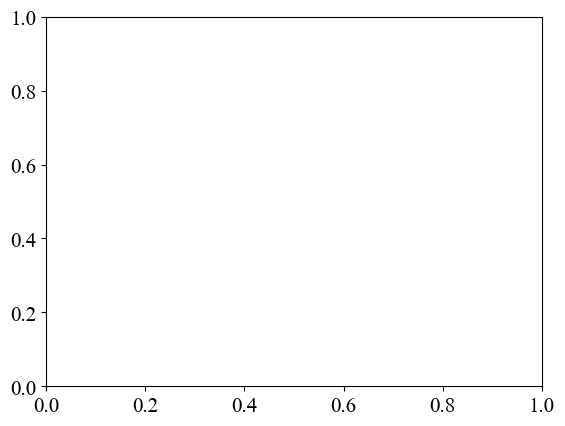

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 0.05,
    'batch_size': 1024, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,#5e-3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'layers': 3,
    'hidden_dim': 128,#512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'embed_dim': 6,#10,
    'beta': 1024, #512
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'bi', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}
precision_noise_levels = np.hstack((0, np.logspace(np.log10(0.002), np.log10(0.15), 40)))
n_repeats = 15

window_range = np.array([0.02, 0.06, 0.1])

precision_mi = []

for window in window_range:
    ds = TimeWindowDataset(os.path.join(data_dir, '2025-03-11'), window_size=window, neuron_label_filter=1, select_x=[10])

    this_params = {**params, 'X_dim': ds.X.shape[1] * ds.X.shape[2], 'Y_dim': ds.Y.shape[1] * ds.Y.shape[2], 'patience': 20}

    mis_test, train_id = train_model_no_eval(ds, this_params)
    model = retrieve_best_model(mis_test, this_params, train_id=train_id, remove_all=True)

    precision_mi.append(precision(precision_noise_levels, ds, model, n_repeats=n_repeats))

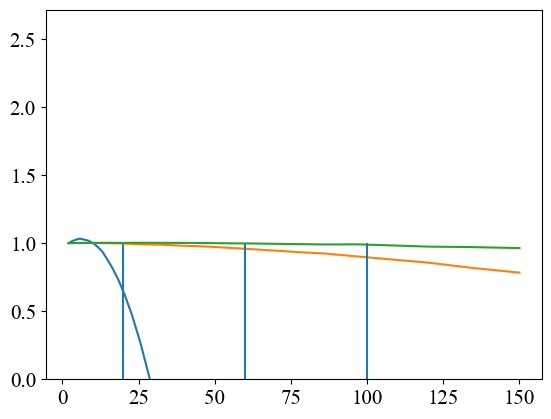

In [23]:
fig, ax = plt.subplots()
for i,window in enumerate(window_range):    
    mean_sig, sd_sig = precision_mi[i][1:].mean(axis=1), precision_mi[i][1:].std(axis=1)
    ax.plot(precision_noise_levels[1:] * 1000, mean_sig / mean_sig[0])
    # ax.fill_between(precision_noise_levels[1:] * 1000, mean_sig, mean_sig - sd_sig, mean_sig + sd_sig)
    ax.vlines(window * 1000, ymin=0, ymax=1)
    ax.set_ylim(0)

2.1818389892578125
Neurons (X): torch.Size([12, 4759184])
Muscles (Y): torch.Size([10, 4759184])
Neuron Labels: ['12', '25', '22', '11', '5', '75', '27', '16', '44', '45', '17', '9']
Muscle Labels: ['rsa', 'rdvm', 'lba', 'ldvm', 'rdlm', 'lsa', 'rax', 'lax', 'rba', 'ldlm']


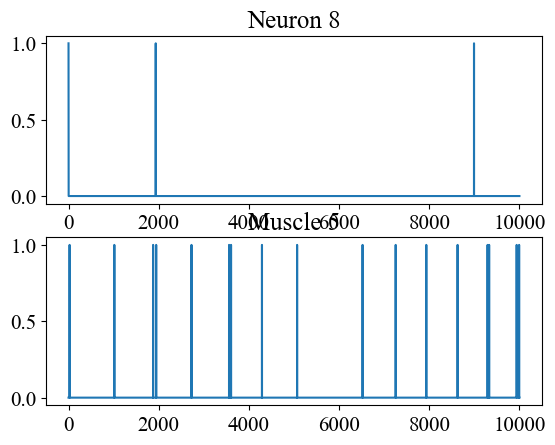

In [6]:
# Read the data and apply some binning/downsampling
period = 0.0001
tic = time.time()
X, Y, x_labels, y_labels, bout_starts = read_spike_data(os.path.join(data_dir, '2025-03-11'), period, neuron_label_filter=1)
print(time.time() - tic)

print(f"Neurons (X): {X.shape}")
print(f"Muscles (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

# Plot sample of activity
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
useneuron = 8
idx = torch.nonzero(X[useneuron,:])[0][0]
fig, ax = plt.subplots(2, 1)
ax[0].plot(X[useneuron,idx:idx+pl].cpu())
ax[1].plot(Y[usemuscle,idx:idx+pl].cpu())
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

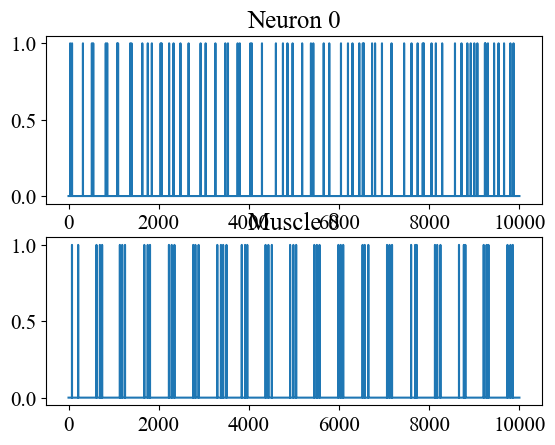

In [22]:
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
useneuron = 0
idx = np.random.choice(torch.nonzero(X[useneuron,:]).cpu().flatten())
fig, ax = plt.subplots(2, 1)
idx = idx + 4000
ax[0].plot(X[useneuron,idx:idx+pl].cpu())
ax[1].plot(Y[usemuscle,idx:idx+pl].cpu())
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

In [12]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 256, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'patience': 15,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'branch': 'expDilation', # Whether to have branched first layer '1', all branched layers 'all', or None if no branch layers
    'stride': 2, # stride of CNN layers. First layer will always be stride=1
    'n_filters': 8, # Number of new filters per layer. Each layer will 2x this number
    'layers': 7,
    'fc_layers': 2, # fully connected layers
    'hidden_dim': 256,
    'activation': nn.LeakyReLU, #nn.Softplus
    'embed_dim': 10,
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}

0.23917388916015625


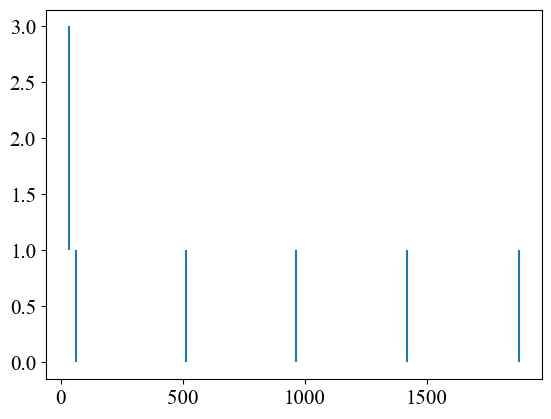

In [4]:
neuron = np.random.choice(X.shape[0])
this_params = {**params, 'embed_dim': 10}
dataset = BatchedDatasetWithNoise(X[[neuron],:], Y, bout_starts, this_params['window_size'], check_activity=True)

fig, ax = plt.subplots(1, 1)

i = np.random.choice(dataset.n_batches)

inds = dataset.batch_indices[i]

ax.vlines(dataset.Y[i,0,1,:].cpu().numpy().nonzero(), 0, 1)
ax.vlines(dataset.X[i,0,:,:].cpu().numpy().nonzero()[1], 1, 2)
ax.vlines(X[neuron, inds[0]:inds[1]].cpu().numpy().nonzero(), 2, 3)

nspike = []
for i in range(dataset.n_batches):
    nspike.append(len(dataset.X[i,0,:,:].cpu().numpy().nonzero()[0]))


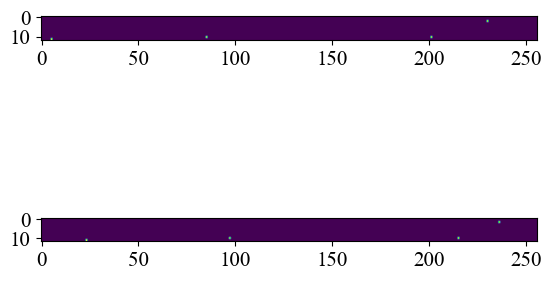

In [119]:
neuron = np.random.choice(X.shape[0])
this_params = {**params, 'embed_dim': 10}
dataset = BatchedDatasetWithNoise(X, Y, bout_starts, this_params['window_size'], check_activity=True)

fig, ax = plt.subplots(2,1)
ax[0].imshow(dataset.X[1,0,:,:].cpu())
dataset.apply_noise(20)
ax[1].imshow(dataset.X[1,0,:,:].cpu())

In [ ]:
torch.mps.empty_cache()
neuron = np.random.choice(X.shape[0])
neuron = 25
print(f'Neuron {neuron}')
this_params = {**params, 'embed_dim': 10}
dataset = BatchedDataset(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
# mis, mis_test, mod = train_cnn_model(dataset, this_params)
mis_test, train_id = train_model_no_eval(dataset, this_params)
mod = retrieve_best_model(mis_test, this_params, train_id=train_id)


Neuron 25
Train time = 5.775474786758423
Test time = 0.24387192726135254
Epoch: 1, DSIB, test: 0.001490626367740333
Train time = 3.781615972518921
Test time = 0.10401201248168945
Epoch: 2, DSIB, test: 0.0032741264440119267
Train time = 3.767526865005493
Test time = 0.1042170524597168
Epoch: 3, DSIB, test: 0.014530785381793976
Train time = 3.861485004425049
Test time = 0.10765218734741211
Epoch: 4, DSIB, test: 0.06576761603355408
Train time = 3.7685561180114746
Test time = 0.10485291481018066
Epoch: 5, DSIB, test: 0.07053261250257492
Train time = 3.777069091796875
Test time = 0.10352206230163574
Epoch: 6, DSIB, test: 0.07763534039258957
Train time = 3.770236015319824
Test time = 0.10445523262023926
Epoch: 7, DSIB, test: 0.06648082286119461
Train time = 3.7765591144561768
Test time = 0.10422706604003906
Epoch: 8, DSIB, test: 0.046533290296792984
Train time = 3.8732051849365234
Test time = 0.1546030044555664
Epoch: 9, DSIB, test: 0.10662282258272171
Train time = 3.8265159130096436
Test ti

Text(0, 0.5, 'MI')

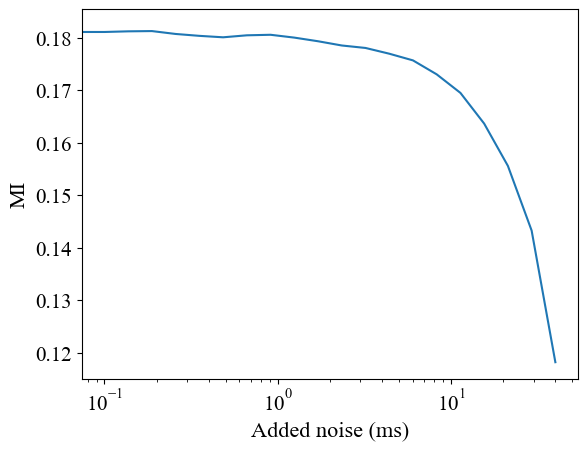

In [6]:
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 20) / period))
n_repeats = 3
with torch.no_grad():
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
    precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
    for j0,prec_noise_amp in enumerate(precision_noise_levels):
        for j1 in range(n_repeats):
            dataset.apply_noise(prec_noise_amp)
            precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()

fig, ax = plt.subplots()
ax.plot(precision_noise_levels * period * 1000, np.mean(precision_mi, axis=1))
ax.set_xscale('log')
ax.set_xlabel('Added noise (ms)')
ax.set_ylabel('MI')

(0.0, 0.10468171461252496)

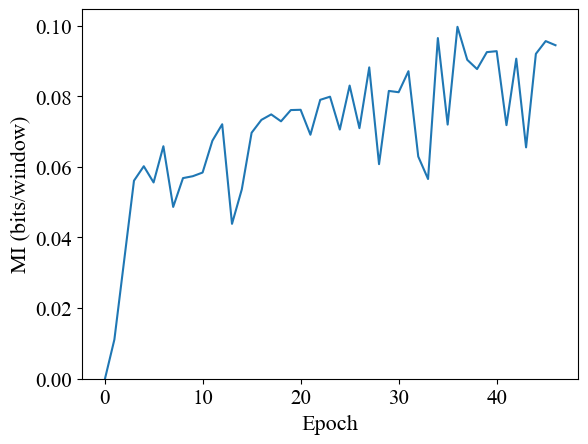

In [7]:
sigma = 1
# plt.plot(mis)
plt.plot(mis_test)
# plt.plot(gaussian_filter1d(mis, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
# plt.plot(gaussian_filter1d(mis_test, sigma=sigma) * np.log2(np.e) / (0.0005 * 512))
plt.xlabel('Epoch')
plt.ylabel('MI (bits/window)')
plt.ylim(0)

# Try subsampling

In [3]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 10,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    'model_cache_dir': model_cache_dir,
    # Critic parameters for the estimator
    'model_func': DSIB, # DSIB or DVSIB
    'branch': 'all', # Whether to have branched first layer '1', all branched layers 'all', or None if no branch layers
    'stride': 2, # stride of CNN layers. First layer will always be stride=1
    'n_filters': 16, # Number of new filters per layer. Each layer will 2x this number
    'layers': 5,
    'fc_layers': 2, # fully connected layers
    'hidden_dim': 256,
    'activation': nn.LeakyReLU, #nn.Softplus
    'embed_dim': 10,
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 256, # If input has more than this many batches, encoder runs are split up for memory management
}

In [ ]:
neuron = 8
dataset = BatchedDataset(X.to(device), Y.to(device), params['window_size'])

split_sizes = np.arange(1,8)

# Generate random subsample indices
indices = []
for ss in split_sizes:
    inds = np.random.choice(dataset.X.shape[0], dataset.X.shape[0], replace=False)
    edges = np.rint(np.linspace(0, dataset.X.shape[0]-1, ss+1)).astype(int)
    for i in range(ss):
        indices.append(inds[edges[i]:edges[i+1]])
mi = np.zeros((len(indices)))
subsets = np.hstack([np.repeat(x, x) for x in split_sizes]) # run length encoding of split_sizes
# Loop over subsets
for i,inds in enumerate(indices):
    # Train model
    mis_test, train_id = train_model_no_eval(dataset, params, subset_indices=inds)
    mod = retrieve_best_model(mis_test, params, train_id=train_id, remove_all=True)
    if i == 0:
        full_mod = mod
    # Run model inference to get MI value
    with torch.no_grad():
        mi[i] = - mod(dataset.X[inds,:,:,:], dataset.Y[inds,:,:,:]).detach().cpu().numpy()

# subsets, mi = subsample_MI(dataset, params)

Epoch: 1, DSIB, test: 0.06805481016635895
Epoch: 2, DSIB, test: 0.29086393117904663
Epoch: 3, DSIB, test: 0.45467162132263184
Epoch: 4, DSIB, test: 0.47382643818855286
Epoch: 5, DSIB, test: 0.5979357361793518
Epoch: 6, DSIB, test: 0.6311761140823364
Epoch: 7, DSIB, test: 0.7176768779754639
Epoch: 8, DSIB, test: 0.7390103340148926
Epoch: 9, DSIB, test: 0.7224146723747253
Epoch: 10, DSIB, test: 0.7119239568710327
Epoch: 11, DSIB, test: 0.651691198348999
Epoch: 12, DSIB, test: 0.6962073445320129
Epoch: 13, DSIB, test: 0.7045944333076477
Epoch: 14, DSIB, test: 0.6539338231086731
Epoch: 15, DSIB, test: 0.5454612970352173
Epoch: 16, DSIB, test: 0.49645063281059265
Epoch: 17, DSIB, test: 0.16294437646865845
Epoch: 18, DSIB, test: 0.13410302996635437
Early stopping triggered after 18 epochs. Best estimator_ts: 0.7390103340148926
Epoch: 1, DSIB, test: 0.0338127426803112
Epoch: 2, DSIB, test: 0.06011990085244179
Epoch: 3, DSIB, test: 0.145842507481575
Epoch: 4, DSIB, test: 0.2260282188653946
Epo

In [5]:
# Inference version of subsampling on full model
def inference_subsampling(model, dataset, split_sizes=np.arange(1,8)):
    indices = []
    for ss in split_sizes:
        inds = np.random.choice(dataset.X.shape[0], dataset.X.shape[0], replace=False)
        edges = np.rint(np.linspace(0, dataset.X.shape[0]-1, ss+1)).astype(int)
        for i in range(ss):
            indices.append(inds[edges[i]:edges[i+1]])
    mi = np.zeros((len(indices)))
    subsets = np.hstack([np.repeat(x, x) for x in split_sizes]) # run length encoding of split_sizes
    # Loop over subsets, run model inference to get MI values
    with torch.no_grad():
        for i,inds in enumerate(indices):
            mi[i] = - model(dataset.X[inds,:,:,:], dataset.Y[inds,:,:,:]).detach().cpu().numpy()
    return subsets, mi

inference_subsets, inference_mi = inference_subsampling(full_mod, dataset)

(0.0, 7.3)

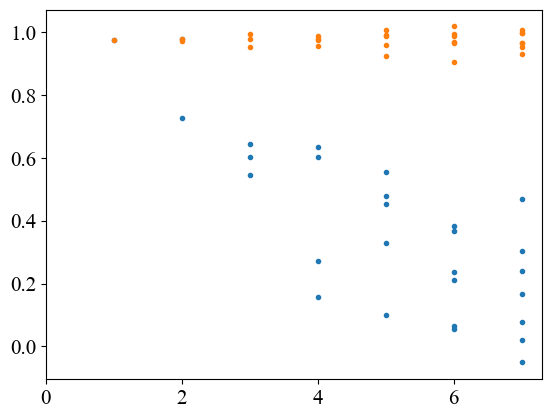

In [8]:
plt.plot(subsets, mi, '.')
plt.plot(inference_subsets, inference_mi, '.')
plt.gca().set_xlim(0)

# Precision


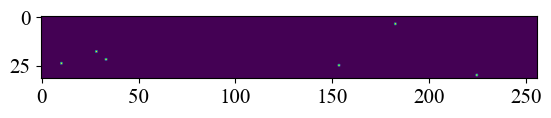

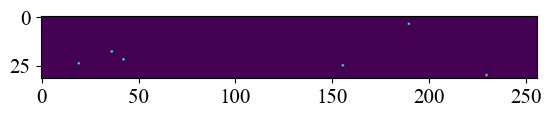

In [64]:
this_params = {**params, 'embed_dim': 10, 'batch_size': 256}
dataset = BatchedDatasetWithNoise(X.to(device), Y.to(device), this_params['batch_size'])

plt.figure()
dataset.apply_noise(0)
plt.imshow(dataset.Xnoise[0,0,:,:].cpu())
plt.figure()
dataset.apply_noise(0.001 / period)
plt.imshow(dataset.Xnoise[0,0,:,:].cpu())

In [ ]:
torch.cuda.empty_cache()
mod.eval()
amts = np.linspace(100,1500,10, dtype=int)
vals = np.zeros_like(amts)
with torch.no_grad():
    for i,amt in enumerate(amts):
        dataset.apply_noise(0)
        inds = np.random.choice(np.arange(dataset.Xnoise.shape[0]), amt)
        vals[i] = - mod(dataset.Xnoise[inds,:,:,:], dataset.Ynoise[inds,:,:,:])
plt.plot(amts, vals)

In [8]:
torch.mps.empty_cache()

# this_params = {**params, 'embed_dim': 10, 'window_size': 256}
torch.mps.synchronize()
tic = time.time()
dataset = BatchedDatasetWithNoise(X.to(device), Y.to(device), this_params['window_size'])
torch.mps.synchronize()
print(f'dataset = {time.time() - tic}')

n_repeats = 3
# noise_levels = torch.arange(period, 20*period, step=period).to(device)
noise_levels = torch.logspace(np.log10(period), np.log10(0.02), 20).to(device)
precision_mi = torch.zeros((len(noise_levels), n_repeats)).to(device)

mod.eval()

with torch.no_grad():
    for i,amp in enumerate(noise_levels):
        for j in range(n_repeats):
            dataset.apply_noise(amp / period)

            # inds = np.random.choice(np.arange(dataset.Xnoise.shape[0]), 2000)
            torch.mps.synchronize()
            tic = time.time()
            precision_mi[i,j] = -models[0](dataset.Xnoise, dataset.Ynoise).detach()
            torch.mps.synchronize()
            print(f'Inference: {time.time() - tic}')


dataset = 0.15633583068847656
Inference: 0.5941340923309326
Inference: 0.6205008029937744
Inference: 0.5042769908905029
Inference: 0.49620890617370605
Inference: 0.49607014656066895
Inference: 0.49566197395324707
Inference: 0.5053088665008545
Inference: 0.5037403106689453
Inference: 0.49646592140197754
Inference: 0.5309922695159912
Inference: 0.5017919540405273
Inference: 0.5031547546386719
Inference: 0.5056519508361816
Inference: 0.5065462589263916
Inference: 0.5328259468078613
Inference: 0.5059599876403809
Inference: 0.5154757499694824
Inference: 0.5013079643249512
Inference: 0.4972820281982422
Inference: 0.49623584747314453
Inference: 0.49387693405151367
Inference: 0.4951040744781494
Inference: 0.5004711151123047
Inference: 0.49389219284057617
Inference: 0.5356400012969971
Inference: 0.5194571018218994
Inference: 0.5167787075042725
Inference: 0.5145699977874756
Inference: 0.5240731239318848
Inference: 0.5170049667358398
Inference: 0.51226806640625
Inference: 0.5134811401367188
Infer

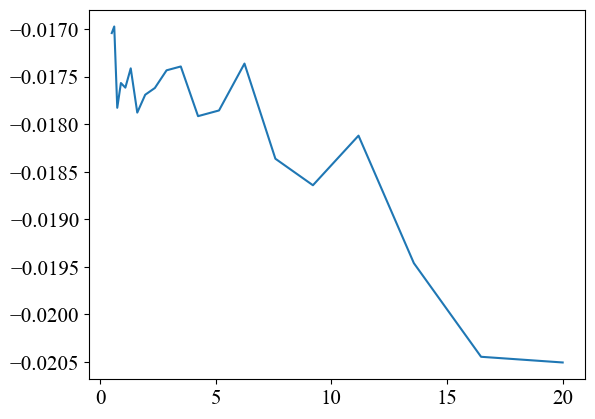

In [9]:
plt.plot(noise_levels.cpu() * 1000, torch.mean(precision_mi, dim=1).cpu())
# plt.gca().set_xscale('log')

# Precision estimation via training (not inference)

Re-training the model with different amounts of noise applied to the data

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 256, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 1e-3,
    'n_trials': 3,
    'patience': 30,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'model_func': DSIB, # DSIB or DVSIB
    'layers': 5,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

neuron = 25

period = 0.0005
noise_range = np.hstack((0, np.logspace(np.log10(period), np.log10(0.01), 10) / period))
mi = np.zeros_like(np.array(noise_range))
mi_test = []
models = []
ids = []
# Precision curve params
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
n_repeats = 5
precision_curves = []

X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)

for i,noise_amp in enumerate(noise_range):
    torch.mps.empty_cache()
    this_params = {**params, 'embed_dim': 10}
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), this_params['window_size'])
    mis_test, train_id = train_model_no_eval_apply_noise(dataset, this_params, model_cache_dir, noise_amp)
    mod = retrieve_best_model(model_cache_dir, mis_test, this_params, train_id=train_id)
    # Store results
    mi_test.append(mis_test)
    models.append(mod)
    ids.append(train_id)
    # Run inference
    with torch.no_grad():
        dataset.apply_noise(noise_amp)
        thismi = - mod(dataset.Xnoise, dataset.Ynoise)
        mi[i] = thismi.detach().cpu()
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)


Train time = 1.280348777770996
Test time = 0.154494047164917
Epoch: 1, DSIB, test: 0.1166582778096199
Train time = 1.273681879043579
Test time = 0.04385209083557129
Epoch: 2, DSIB, test: 0.18439489603042603
Train time = 1.2437896728515625
Test time = 0.0436711311340332
Epoch: 3, DSIB, test: 0.1823572814464569
Train time = 1.2447450160980225
Test time = 0.04325294494628906
Epoch: 4, DSIB, test: 0.23784030973911285
Train time = 1.2418811321258545
Test time = 0.044243812561035156
Epoch: 5, DSIB, test: 0.2471899688243866
Train time = 1.244704008102417
Test time = 0.04499697685241699
Epoch: 6, DSIB, test: 0.20079758763313293
Train time = 1.2425282001495361
Test time = 0.04319000244140625
Epoch: 7, DSIB, test: 0.11532793939113617
Train time = 1.2433910369873047
Test time = 0.04400205612182617
Epoch: 8, DSIB, test: 0.14835144579410553
Train time = 1.2450592517852783
Test time = 0.044033050537109375
Epoch: 9, DSIB, test: -0.09854907542467117
Train time = 1.2392871379852295
Test time = 0.044008

Text(0, 0.5, 'MI (bits/s)')

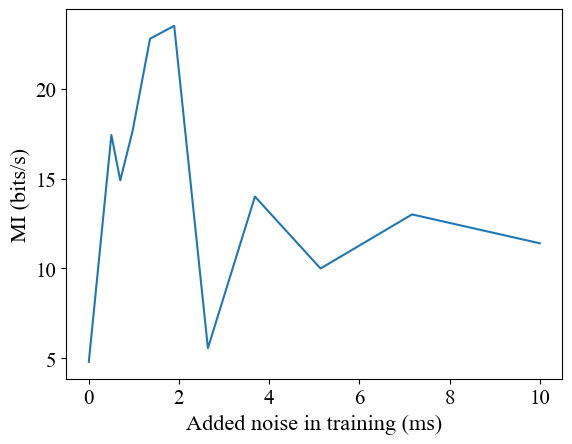

In [93]:
torch.mps.empty_cache()
plt.plot(noise_range * period * 1000, mi * np.log2(np.e) / params['window_size'] / period)
plt.gca().set_xlabel('Added noise in training (ms)')
plt.gca().set_ylabel('MI (bits/s)')

Text(0, 0.5, 'Measured precision (ms)')

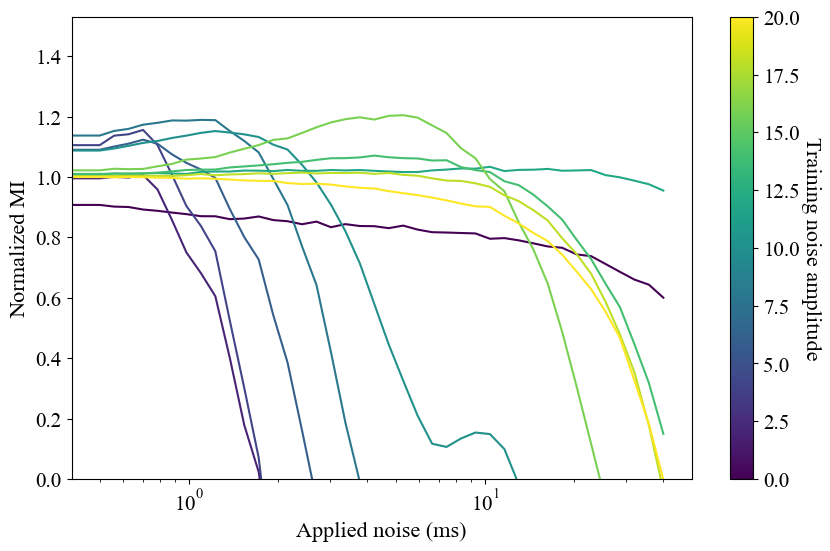

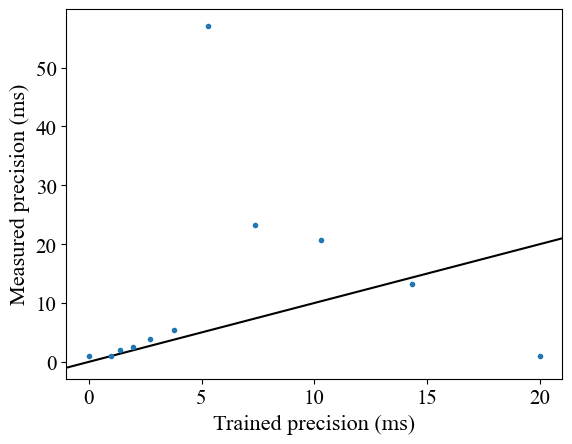

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.cm.get_cmap('viridis')
for i in range(len(noise_range)):
    color_pos = i / (len(noise_range) - 1) if len(noise_range) > 1 else 0
    color = cmap(color_pos)
    vals = np.mean(precision_curves[i], axis=1) * np.log2(np.e) / params['window_size'] / period
    ax.plot(precision_noise_levels * period * 1000, vals / vals[0], color=color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=noise_range[-1]))
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Training noise amplitude', rotation=270, labelpad=15)
ax.set_xscale('log')
ax.set_ylim(0)
ax.set_xlabel('Applied noise (ms)')
ax.set_ylabel('Normalized MI')

fig, ax = plt.subplots()
precision = []
for curve in precision_curves:
    val = np.mean(curve, axis=1)
    val = val / val[0]
    precision.append(precision_noise_levels[np.argmax(val < 1)])

ax.axline([0,0], slope=1, color='k')
ax.plot(noise_range, np.array(precision),'.')
ax.set_xlabel('Trained precision (ms)')
ax.set_ylabel('Measured precision (ms)')

Text(0, 0.5, 'Normalized MI')

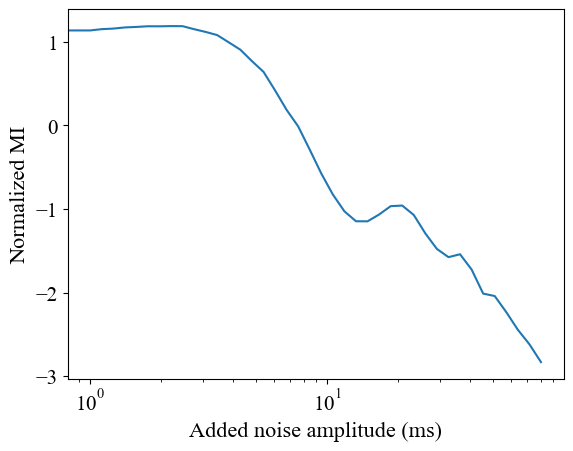

In [118]:
curve = np.mean(precision_curves[4], axis=1)
curve = curve / curve[0]
plt.plot(precision_noise_levels, curve)
curve
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Added noise amplitude (ms)')
plt.gca().set_ylabel('Normalized MI')

# Vary dataset binning, see how it changes information learned/found

In [ ]:
params = {
    # Optimizer parameters (for training)
    'epochs': 250,
    'window_size': 512, # Window of time the estimator operates on, in samples
    'batch_size': 128, # Number of windows estimator processes at any time
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 15,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    'train_fraction': 0.9,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'model_func': DSIB, # DSIB or DVSIB
    'embed_dim': 10,
    'layers': 4,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.LeakyReLU, #nn.Softplus
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'max_n_batches': 1000, # If input has more than this many batches, encoder runs are split up for memory management
}

neuron = 25

period_range = np.logspace(np.log10(0.00005), np.log10(0.01), 20)
mi_test = []
models = []
ids = []
precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
n_repeats = 3
precision_curves = []
for i,period in enumerate(period_range):
    print(f'Period = {period} s')
    X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
    X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
    torch.mps.empty_cache()
    dataset = BatchedDatasetWithNoise(X[[neuron],:].to(device), Y.to(device), params['window_size'])
    mis_test, train_id = train_model_no_eval(dataset, params, model_cache_dir)
    mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
    # Store results
    mi_test.append(mis_test)
    models.append(mod)
    ids.append(train_id)
    with torch.no_grad():
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - mod(dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)


Period = 4.9999999999999996e-05 s
Train time = 8.385380744934082
Test time = 0.21169400215148926
Epoch: 1, DSIB, test: 0.006829846650362015
Train time = 7.9879150390625
Test time = 0.2163081169128418
Epoch: 2, DSIB, test: 0.03982722386717796
Train time = 7.946149826049805
Test time = 0.2069230079650879
Epoch: 3, DSIB, test: 0.03663326054811478
Train time = 7.95436692237854
Test time = 0.20759916305541992
Epoch: 4, DSIB, test: 0.04140667989850044
Train time = 7.903834342956543
Test time = 0.20545005798339844
Epoch: 5, DSIB, test: 0.04298585280776024
Train time = 7.910940885543823
Test time = 0.2080216407775879
Epoch: 6, DSIB, test: 0.03641291707754135
Train time = 7.91900110244751
Test time = 0.20574522018432617
Epoch: 7, DSIB, test: 0.03459368646144867
Train time = 7.93487286567688
Test time = 0.2082958221435547
Epoch: 8, DSIB, test: 0.035471778362989426
Train time = 7.982103109359741
Test time = 0.20671892166137695
Epoch: 9, DSIB, test: 0.04286494106054306
Train time = 7.9067850112915

In [32]:
n_repeats = 3
precision_curves = []
for i,period in enumerate(period_range):
    with torch.no_grad():
        X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), period)
        X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
        torch.mps.empty_cache()
        precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40) / period))
        # Precision curve for each 
        precision_mi = np.zeros((len(precision_noise_levels), n_repeats))
        for j0,prec_noise_amp in enumerate(precision_noise_levels):
            for j1 in range(n_repeats):
                dataset.apply_noise(prec_noise_amp)
                precision_mi[j0,j1] = - models[i](dataset.Xnoise, dataset.Ynoise).detach().cpu().numpy()
        precision_curves.append(precision_mi)

Text(0, 0.5, 'MI (bits/s)')

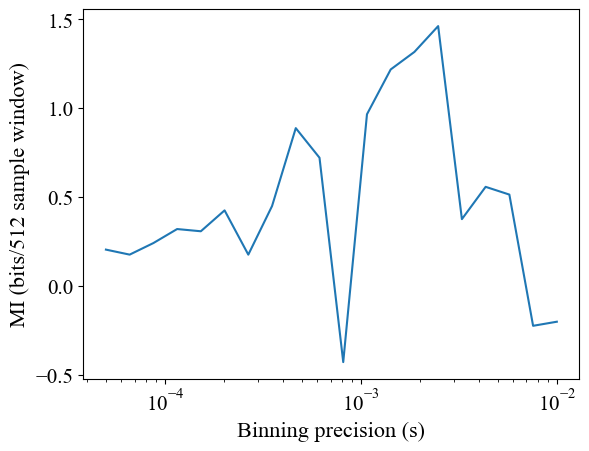

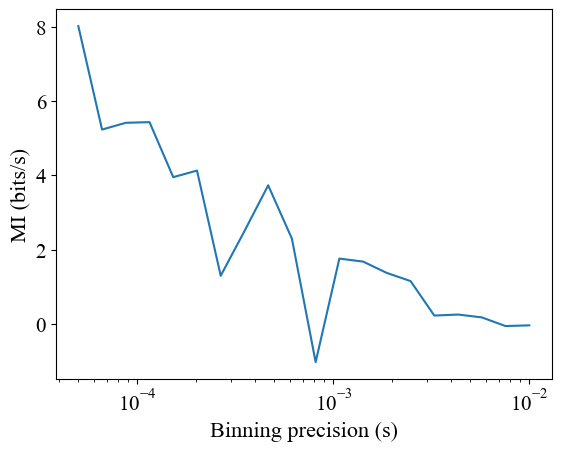

In [19]:
mi = np.array([np.mean(p[0,:]) for p in precision_curves])
plt.plot(np.array(period_range), mi * np.log2(np.e))
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Binning precision (s)')
ax.set_ylabel('MI (bits/512 sample window)')

plt.figure()
plt.plot(np.array(period_range), mi * np.log2(np.e) / params['window_size'] / period_range)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('Binning precision (s)')
ax.set_ylabel('MI (bits/s)')

In [42]:
period_range * 1000

array([ 0.05      ,  0.06608104,  0.08733407,  0.11542251,  0.15254479,
        0.20160635,  0.26644714,  0.35214206,  0.46539824,  0.61507997,
        0.81290243,  1.07434871,  1.41988152,  1.87654485,  2.48008057,
        3.2777259 ,  4.33191049,  5.7251427 ,  7.56646728, 10.        ])

Text(0, 0.5, 'Normalized MI')

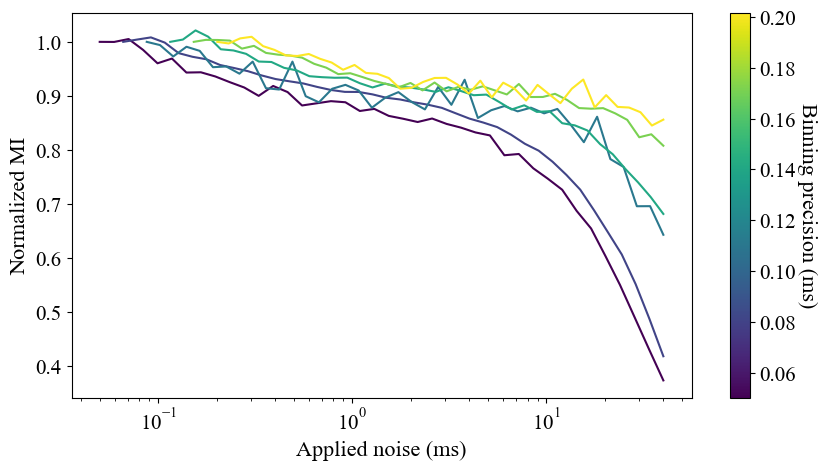

In [55]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = plt.cm.get_cmap('viridis')
prange = period_range[0:6]
for i, period in enumerate(prange):
    precision_noise_levels = np.hstack((0, np.logspace(np.log10(period), np.log10(0.04), 40)))
    color_pos = i / (len(prange) - 1) if len(prange) > 1 else 0
    color = cmap(color_pos)
    vals = np.mean(precision_curves[i], axis=1) * np.log2(np.e) / params['window_size'] / period
    ax.plot(precision_noise_levels[1:] * 1000, vals[1:] / vals[1], color=color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=prange[0]*1000, vmax=prange[-1]*1000))
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Binning precision (ms)', rotation=270, labelpad=15)
ax.set_xscale('log')
# ax.set_ylim()
ax.set_xlabel('Applied noise (ms)')
ax.set_ylabel('Normalized MI')

Text(0, 0.5, 'Normalized MI')

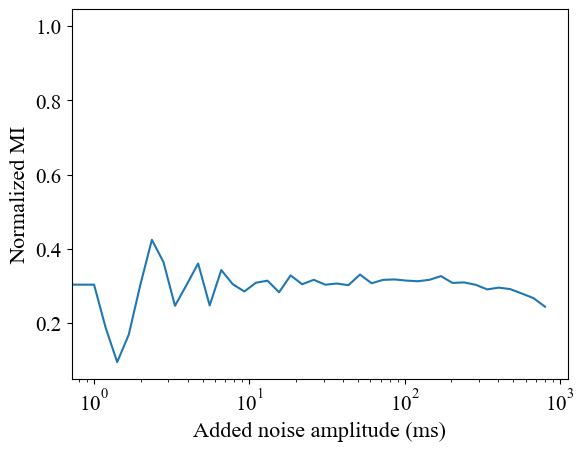

In [18]:
curve = np.mean(precision_curves[0], axis=1)
curve = curve / curve[0]
plt.plot(precision_noise_levels, curve)
curve
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Added noise amplitude (ms)')
plt.gca().set_ylabel('Normalized MI')

In [26]:
from tqdm.auto import tqdm
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}
models = {}
ids = {}
batch_size_range = np.array([128, 256, 512, 1024])
neuron = np.random.choice(X.shape[0])

for bs in batch_size_range:
    for dz in tqdm(range(1, params['max_dz']+1)):
        print(f'Starting dz = {dz}')
        for j in range(params['n_trials']):
            this_params = {**params, 'embed_dim': dz, 'batch_size': bs}
            print(f'batch size = {bs}, dz = {dz}, trial = {j+1}')
            torch.cuda.empty_cache()
            dataset = BatchedDataset(X[[neuron],:], Y, this_params['batch_size'])
            full_dataset = create_cnn_data_split(dataset, 60, train_fraction=0.9, eval_fraction=0.9, device=device)
            mis, mis_test, _ = train_cnn_model(DSIB, full_dataset, this_params)
            # full_dataset = create_cnn_data_split(dataset, train_fraction=0.9, eval_fraction=0.9, device=device)
            # mis, mis_test = train_model(DSIB, full_dataset, this_params)
            # mis_test, train_id = train_model_no_eval(DSIB, full_dataset, this_params, model_cache_dir)
            # mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
            # Store results
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            mi[key] = mis
            mi_test[key] = mis_test
            # models[key] = mod
            # ids[key] = train_id
torch.cuda.empty_cache()


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 128, dz = 1, trial = 1
Train time = 0.7406737804412842
Eval time = 0.016013622283935547
Test time = 0.005005598068237305
Epoch: 1, DSIB, train: -8.574826097174082e-06, test: -8.78915216162568e-06
Train time = 0.5104649066925049
Eval time = 0.002001047134399414
Test time = 0.002002716064453125
Epoch: 2, DSIB, train: -3.644090156740276e-06, test: -3.7664101455447963e-06
Train time = 0.5234763622283936
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 3, DSIB, train: -1.7990419109992217e-06, test: -2.378149929427309e-06
Train time = 0.5004549026489258
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 4, DSIB, train: -1.598914082023839e-06, test: -1.5391580063806032e-06
Train time = 0.5214755535125732
Eval time = 0.002002716064453125
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -8.14888323930063e-07, test: -1.0640453638188774e-06
Train time = 0.5054595470428467
Eval time = 0.002002716064453125
Test time =

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 256, dz = 1, trial = 1
Train time = 0.43439412117004395
Eval time = 0.01401376724243164
Test time = 0.005004405975341797
Epoch: 1, DSIB, train: -0.00040275955689139664, test: -0.00039908778853714466
Train time = 0.45641469955444336
Eval time = 0.002002239227294922
Test time = 0.0009999275207519531
Epoch: 2, DSIB, train: -2.252435115224216e-05, test: -2.9693497708649375e-05
Train time = 0.4253857135772705
Eval time = 0.0020024776458740234
Test time = 0.002001047134399414
Epoch: 3, DSIB, train: -3.789873744608485e-06, test: -5.052479991718428e-06
Train time = 0.42738842964172363
Eval time = 0.0020017623901367188
Test time = 0.003002643585205078
Epoch: 4, DSIB, train: -1.6487376797158504e-06, test: -1.6182557374122553e-06
Train time = 0.4263877868652344
Eval time = 0.002187490463256836
Test time = 0.0010008811950683594
Epoch: 5, DSIB, train: -1.8684459064388648e-06, test: -1.3424544249573955e-06
Train time = 0.4133765697479248
Eval time = 0.002000570297241211


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 512, dz = 1, trial = 1
Train time = 0.6295723915100098
Eval time = 0.016015052795410156
Test time = 0.007005929946899414
Epoch: 1, DSIB, train: -0.01148455310612917, test: -0.01034874189645052
Train time = 0.6191556453704834
Eval time = 0.0030028820037841797
Test time = 0.0020017623901367188
Epoch: 2, DSIB, train: -0.00048147584311664104, test: -0.00042977623525075614
Train time = 0.6265697479248047
Eval time = 0.0020020008087158203
Test time = 0.0010004043579101562
Epoch: 3, DSIB, train: -6.341320113278925e-05, test: -6.500879680970684e-05
Train time = 0.6385796070098877
Eval time = 0.0020020008087158203
Test time = 0.0020020008087158203
Epoch: 4, DSIB, train: -1.6865586076164618e-05, test: -1.9105924366158433e-05
Train time = 0.6155598163604736
Eval time = 0.002002239227294922
Test time = 0.0020017623901367188
Epoch: 5, DSIB, train: -1.0816255780810025e-05, test: -1.3565530025516637e-05
Train time = 0.6215651035308838
Eval time = 0.0020024776458740234
Tes

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 1024, dz = 1, trial = 1
Train time = 0.5445020198822021
Eval time = 0.020017385482788086
Test time = 0.00600433349609375
Epoch: 1, DSIB, train: -0.012846967205405235, test: -0.01035755593329668
Train time = 0.5034575462341309
Eval time = 0.0020012855529785156
Test time = 0.002001523971557617
Epoch: 2, DSIB, train: -0.005014576483517885, test: -0.00434390502050519
Train time = 0.5044593811035156
Eval time = 0.0030014514923095703
Test time = 0.002002716064453125
Epoch: 3, DSIB, train: -0.0008515996159985662, test: -0.0006777612725272775
Train time = 0.5054595470428467
Eval time = 0.0020017623901367188
Test time = 0.002001523971557617
Epoch: 4, DSIB, train: -8.7614098447375e-05, test: -7.642570562893525e-05
Train time = 0.5024571418762207
Eval time = 0.0020017623901367188
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -5.419558874564245e-06, test: -4.655436441680649e-06
Train time = 0.5024561882019043
Eval time = 0.002001523971557617
Test time = 0.002

KeyError: 'trial_0_dz_1_bs_20'

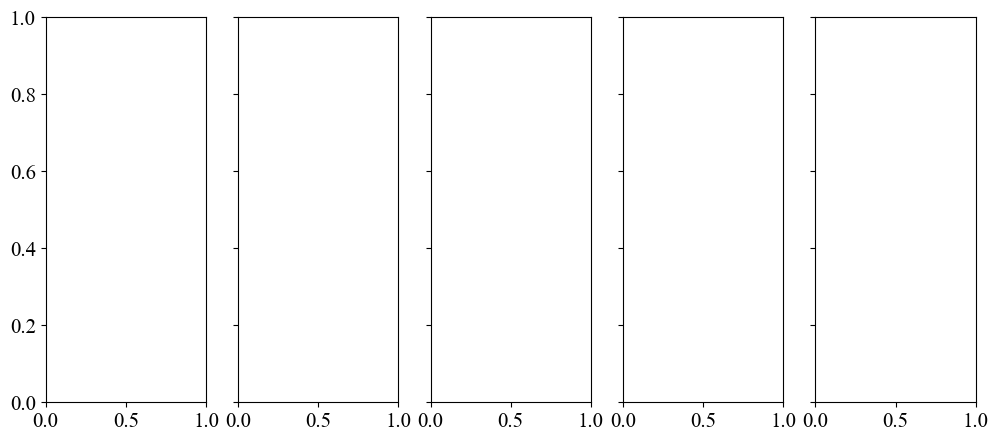

In [34]:
# Define sigma, a small number is usually the best choice
sigma=1 # (or 2 at most)

fig, ax = plt.subplots(1, len(batch_size_range), figsize=(12,5), sharey=True)
for i,bs in enumerate(batch_size_range):    
    dz_means, dz_stds = [], []
    dz_train_means, dz_train_stds = [], []
    for dz in range(1, params['max_dz']+1):
        mi_trials = []
        mi_train = []
        for j in range(params['n_trials']):
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            # Convert Nan to zeros and smooth
            # test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) / bs * np.log2(np.e) * 1000
            train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            # Pick the epoch with highest test value and get corresponding train
            best = np.argmax(test)
            mi_trials.append(test[best])
            mi_train.append(train[best])
        dz_means.append(np.mean(np.array(mi_trials)).flatten())
        dz_stds.append(np.std(np.array(mi_trials)).flatten())
        dz_train_means.append(np.mean(np.array(mi_train)).flatten())
        dz_train_stds.append(np.std(np.array(mi_train)).flatten())
    b = ax[i].errorbar(
        range(1, params['max_dz']+1), np.array(dz_means).flatten(), 
        yerr=np.array(dz_stds).flatten(), 
        fmt='s:', capsize=4)
    # ax[i].errorbar(
    #     range(1, params['max_dz']+1), np.array(dz_train_means).flatten(), 
    #     yerr=np.array(dz_train_stds).flatten(), 
    #     fmt='s:', capsize=4)

    # Set title and scales
    ax[i].set_title(str(bs))
    ax[i].set_xlabel(r'$dz$')
    if i == 0:
        ax[i].set_ylabel(r'$I(X;Y) \text{(bits/s)}$');
    # ax[i].set_ylim(-1, 4)


trial_0_dz_10_bs_64


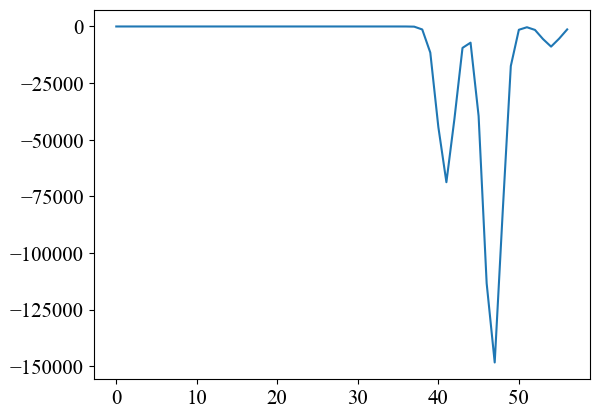

In [72]:
key = random.choice(list(mi_test.keys()))
sigma = 1
# plt.plot(gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma))
plt.plot(gaussian_filter1d(np.nan_to_num(mi_test[key]) * np.log2(np.e), sigma=sigma))
# plt.gca().set_ylim(0)
print(key)

In [82]:
import pickle

with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(mi_test, f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(ids, f)


In [91]:
ids

{'trial_0_dz_5_bs_64': 'DSIB_dz-5_bs-64_8fd6f693-0e8c-4050-80f0-71743727faf4',
 'trial_1_dz_5_bs_64': 'DSIB_dz-5_bs-64_53c1ac4c-c23f-4fb7-b0de-03609854555d',
 'trial_2_dz_5_bs_64': 'DSIB_dz-5_bs-64_980c7b88-ae7e-45c8-8654-43988f324259',
 'trial_0_dz_6_bs_64': 'DSIB_dz-6_bs-64_f5780180-bfd3-435e-b811-ea7695d4a1b5',
 'trial_1_dz_6_bs_64': 'DSIB_dz-6_bs-64_bd177624-0f1d-47e3-9b66-3efe1affcb26',
 'trial_2_dz_6_bs_64': 'DSIB_dz-6_bs-64_e444d9e9-1f41-4509-8b87-95f2bcb4c6ba',
 'trial_0_dz_7_bs_64': 'DSIB_dz-7_bs-64_9dc5f773-c58a-41b1-8d58-f154bc18fe83',
 'trial_1_dz_7_bs_64': 'DSIB_dz-7_bs-64_136f4efa-0772-4a42-b8d1-163fcca65eda',
 'trial_2_dz_7_bs_64': 'DSIB_dz-7_bs-64_aa666a3e-dd74-47c8-9e75-a2260fe347af',
 'trial_0_dz_8_bs_64': 'DSIB_dz-8_bs-64_aaf1e6a7-8d80-4aba-bfe0-8fc840cb522f',
 'trial_1_dz_8_bs_64': 'DSIB_dz-8_bs-64_ef96a2d7-2bcc-45d7-b9ec-20ad29bfc0a7',
 'trial_2_dz_8_bs_64': 'DSIB_dz-8_bs-64_b53fd0ff-c038-4b42-b96d-2a9a32ea69e8',
 'trial_0_dz_9_bs_64': 'DSIB_dz-9_bs-64_6ce81eb9-0f7

In [ ]:
with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)

Okay, so running on the whole dataset takes a long time. 


Scheme for a given moth:
- X embedding dimension sizes
- Y repeats at each embedding dim size
- Z batch sizes